In [31]:
"""
Standalone implementation of the Kang-Schafer continuous treatment simulation.
This script directly implements the permutation weighting approach from the R code,
without relying on external packages.

Based on the R implementation in:
- run_ks_continuous_sim.R
- kang_schafer_continuous.R
- continuous_simulation.R
- weighting.R
- weighting-class.R
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import os
from datetime import datetime
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression
from skmisc.loess import loess
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import time

from permutation_weighting.estimator import PW 

# Set random seed for reproducibility
np.random.seed(100)

def create_kang_schafer_continuous_dgp(n, misspecified=False, extraneous_covs=0, trt_noise_sd=1, logit=True):
    """
    Generate data according to Kang and Schafer (2007) simulation with continuous treatment.
    Directly matches the create_kang_schafer_continuous_dgp function in kang_schafer_continuous.R
    """
    # Generate true covariates (matching R's mvrnorm)
    sigma = np.eye(4 + extraneous_covs)
    mus = np.zeros(4 + extraneous_covs)
    X_true = np.random.multivariate_normal(mus, sigma, n)
    
    # Set coefficients for treatment (matches R)
    co = np.zeros(4 + extraneous_covs)
    co[:4] = np.array([1, -0.5, 0.25, 0.1])
    
    # Linear predictor for treatment
    z_score = np.dot(X_true, co)
    
    # Treatment function: R uses 1/(1+exp(z)) which decreases as z increases
    trt_fn = lambda z: 1 / (1 + np.exp(z)) if logit else z
    
    # True outcome (without treatment effect)
    Outcome = 210 + 27.4 * X_true[:, 0] + 13.7 * X_true[:, 1] + 13.7 * X_true[:, 2] + 13.7 * X_true[:, 3]
    
    # Random noise for outcome
    outcome_noise = np.random.normal(0, 1, n)
    
    # Function to draw dosage (treatment value)
    def draw_dose():
        noise = np.random.normal(0, trt_noise_sd, n)
        return z_score + noise
    
    # Function to calculate test points for evaluation
    def draw_test_points(n_points):
        q = np.linspace(0.05, 0.95, n_points)
        Vz_score = np.dot(np.dot(co, sigma), co)
        Ez_score = np.sum(mus * co)
        test_noise = norm.ppf(q, loc=Ez_score, scale=np.sqrt(Vz_score) + trt_noise_sd)
        return Ez_score + test_noise
    
    # Function to draw outcomes given treatment values
    def draw_outcome(A):
        return Outcome + trt_fn(A) + outcome_noise
    
    # Generate observed covariates (potentially misspecified)
    if misspecified:
        X = np.column_stack([
            np.exp(X_true[:, 0] / 2),
            X_true[:, 1] * (1 + np.exp(X_true[:, 0])) ** (-1) + 10,
            (X_true[:, 0] * X_true[:, 2] / 25 + 0.6) ** 3,
            (X_true[:, 1] + X_true[:, 3] + 20) ** 2
        ])
        
        # Add extraneous covariates if specified
        if extraneous_covs > 0:
            X = np.column_stack([X, X_true[:, 4:]])
    else:
        X = X_true.copy()
    
    return {
        'draw_dose': draw_dose,
        'draw_outcome': draw_outcome,
        'draw_test_points': draw_test_points,
        'data': X,
        'X': X,
        'X_true': X_true,
        'Outcome': Outcome,
        'trt_fn': trt_fn,
        'z_score': z_score,
        'outcome_noise': outcome_noise
    }

def compute_gps_weights(X, A):
    """
    Compute generalized propensity score weights for continuous treatment.
    This matches the 'ps' method in compute_weights_continuous function.
    """
    # Fit linear model predicting treatment
    model = LogisticRegression(max_iter=2000)
    model.fit(X, (A > np.median(A)).astype(int))  # Dichotomize treatment for logistic regression
    
    # Get predicted probabilities
    predicted_probs = model.predict_proba(X)[:, 1]
    
    # Generate weights
    weights = 1 / (predicted_probs * (A > np.median(A)) + (1 - predicted_probs) * (A <= np.median(A)))
    
    # Normalize and stabilize
    weights = np.clip(weights, np.percentile(weights, 2), np.percentile(weights, 98))
    weights = weights / np.mean(weights) * len(weights)
    
    return weights

def compute_npcbps_weights(X, A):
    """
    Non-parametric covariate balancing propensity score for continuous treatment.
    Simplified version of the R implementation.
    """
    from sklearn.preprocessing import PolynomialFeatures
    
    # Create polynomial features for better balance
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Fit model for treatment
    model = LogisticRegression(max_iter=2000)
    model.fit(X, (A > np.median(A)).astype(int))  # Dichotomize for logistic regression
    
    # Get predicted probabilities
    predicted_probs = model.predict_proba(X)[:, 1]
    
    # Initial weights
    weights = 1 / (predicted_probs * (A > np.median(A)) + (1 - predicted_probs) * (A <= np.median(A)))
    weights = weights / np.mean(weights) * len(weights)
    
    # Iteratively adjust weights to balance covariates
    for _ in range(5):
        # Calculate moments
        w_norm = weights / np.sum(weights)
        weighted_moments = np.sum(X_poly * w_norm[:, np.newaxis], axis=0)
        unweighted_moments = np.mean(X_poly, axis=0)
        
        # Calculate imbalance
        imbalance = weighted_moments - unweighted_moments
        
        # Update weights using exponential tilting
        adjustment_factors = np.sum(X_poly * imbalance, axis=1)
        adjustment_factors = np.clip(adjustment_factors, -10, 10)  # Prevent overflow
        adjustment = np.exp(-0.01 * adjustment_factors)
        weights = weights * adjustment
        
        # Normalize
        weights = weights / np.mean(weights) * len(weights)
    
    # Final stabilization
    weights = np.clip(weights, np.percentile(weights, 2), np.percentile(weights, 98))
    weights = weights / np.mean(weights) * len(weights)
    
    return weights

def bootstrap_irmse(results_df, B=200):
    # 1. filter to the raw differences
    df = results_df[results_df['metric'] == 'difference'].copy()
    
    # 2. compute per-simulation IRMSE summaries
    per_sim = df.groupby(
        ['sample_size', 'method', 'estimator', 'model', 'simulation']
    )['value'].apply(lambda d: np.sqrt(np.mean(d**2))).reset_index(name='irmse')
    
    # 3. bootstrap the summaries
    boot_records = []
    # group by everyone except simulation
    group_cols = ['sample_size', 'method', 'estimator', 'model']
    for key_vals, group in per_sim.groupby(group_cols):
        irmse_vals = group['irmse'].values
        for _ in range(B):
            sampled = np.random.choice(irmse_vals, size=len(irmse_vals), replace=True)
            boot_records.append(dict(zip(group_cols, key_vals), irmse=sampled.mean()))
    
    boot_df = pd.DataFrame(boot_records)
    
    # 4. compute mean + sem
    final = (
        boot_df
        .groupby(group_cols)['irmse']
        .agg(value='mean', sem='std')
        .reset_index()
    )
    final['metric'] = 'Integrated RMSE'
    return final

def bootstrap_bias(results_df, B=200):
    # 1. filter
    df = results_df[results_df['metric'] == 'difference'].copy()
    
    # 2. per-simulation absolute bias
    per_sim = df.groupby(
        ['sample_size', 'method', 'estimator', 'model', 'simulation']
    )['value'].apply(lambda d: np.mean(np.abs(d))).reset_index(name='ibias')
    
    # 3. bootstrap
    boot_records = []
    group_cols = ['sample_size', 'method', 'estimator', 'model']
    for key_vals, group in per_sim.groupby(group_cols):
        ibias_vals = group['ibias'].values
        for _ in range(B):
            sampled = np.random.choice(ibias_vals, size=len(ibias_vals), replace=True)
            boot_records.append(dict(zip(group_cols, key_vals), ibias=sampled.mean()))
    
    boot_df = pd.DataFrame(boot_records)
    
    # 4. aggregate
    final = (
        boot_df
        .groupby(group_cols)['ibias']
        .agg(value='mean', sem='std')
        .reset_index()
    )
    final['metric'] = 'Integrated Mean Absolute Bias'
    return final

# def bootstrap_irmse(results_df, B=200):
#     """
#     Bootstrap the Integrated RMSE, directly following the R implementation.
#     
#     Parameters:
#     -----------
#     results_df : DataFrame
#         DataFrame containing simulation results with columns:
#         - simulation: Simulation iteration
#         - method: Weighting method
#         - sample_size: Sample size
#         - test_point: The test point value
#         - difference: Equivalent to 'value' in our structure - difference between estimated and true effect
#     B : int
#         Number of bootstrap iterations
#     
#     Returns:
#     --------
#     DataFrame: Results with bootstrapped IRMSE and standard errors
#     """
#     # Filter to only include difference metric
#     df = results_df[results_df['metric'] == 'difference'].copy()
#     
#     # Initialize storage for bootstrap results
#     bootstrap_results = []
#     
#     for b in range(B):
#         # Sample iterations with replacement - this matches the R implementation
#         sampled_iters = np.random.choice(df['simulation'].unique(), 
#                                         size=len(df['simulation'].unique()), 
#                                         replace=True)
#         
#         # Create bootstrapped dataset by combining sampled iterations
#         bootstrap_df = pd.concat([df[df['simulation'] == iter_id] for iter_id in sampled_iters])
#         
#         rmse_by_point = bootstrap_df.groupby(
#             ['sample_size', 'method', 'estimator', 'model', 'test_point']
#         )['value'].apply(
#             lambda x: np.sqrt(np.mean(x**2))
#         ).reset_index(name='rmse')
#         
#         # Calculate mean RMSE across test points
#         irmse = rmse_by_point.groupby(
#             ['sample_size', 'method', 'estimator', 'model']
#         )['rmse'].apply(
#             lambda x: np.mean(x)
#         ).reset_index(name='irmse')
#         
#         # # For each combination of sample_size, method, estimator, model, test_point
#         # # Calculate RMSE - direct equivalent to rmse=sqrt(mean(value^2)) in R
#         # rmse_by_point = bootstrap_df.groupby(['sample_size', 'method', 'estimator', 'model', 'test_point']).apply(
#         #     lambda x: np.sqrt(np.mean(x['value']**2))
#         # ).reset_index(name='rmse')
#         # 
#         # # Group by everything except test_point and calculate mean RMSE
#         # # This is the integrated RMSE across test points - matches R's mean(rmse)
#         # irmse = rmse_by_point.groupby(['sample_size', 'method', 'estimator', 'model']).apply(
#         #     lambda x: np.mean(x['rmse'])
#         # ).reset_index(name='irmse')
#         # 
#         bootstrap_results.append(irmse)
#     
#     # Combine all bootstrap results
#     all_bootstraps = pd.concat(bootstrap_results, ignore_index=True)
#     
#     # Calculate mean and standard error of IRMSE for each group
#     final_results = all_bootstraps.groupby(['sample_size', 'method', 'estimator', 'model']).agg(
#         value=('irmse', 'mean'),
#         sem=('irmse', 'std')
#     ).reset_index()
#     
#     # Add metric column to identify these results
#     final_results['metric'] = 'Integrated RMSE'
#     
#     return final_results
# 
# def bootstrap_bias(results_df, B=200):
#     """
#     Bootstrap the Integrated Mean Absolute Bias, directly following the R implementation.
#     
#     Parameters:
#     -----------
#     results_df : DataFrame
#         DataFrame containing simulation results with columns:
#         - simulation: Simulation iteration
#         - method: Weighting method
#         - sample_size: Sample size
#         - test_point: The test point value
#         - difference: Equivalent to 'value' in our structure - difference between estimated and true effect
#     B : int
#         Number of bootstrap iterations
#     
#     Returns:
#     --------
#     DataFrame: Results with bootstrapped Integrated Bias and standard errors
#     """
#     # Filter to only include difference metric
#     df = results_df[results_df['metric'] == 'difference'].copy()
#     
#     # Initialize storage for bootstrap results
#     bootstrap_results = []
#     
#     for b in range(B):
#         # Sample iterations with replacement - this matches the R implementation
#         sampled_iters = np.random.choice(df['simulation'].unique(), 
#                                         size=len(df['simulation'].unique()), 
#                                         replace=True)
#         
#         # Create bootstrapped dataset by combining sampled iterations
#         bootstrap_df = pd.concat([df[df['simulation'] == iter_id] for iter_id in sampled_iters])
#         
#         # Calculate absolute bias by aggregating only the value column
#         bias_by_point = bootstrap_df.groupby(
#             ['sample_size', 'method', 'estimator', 'model', 'test_point']
#         )['value'].apply(
#             lambda x: np.abs(np.mean(x))
#         ).reset_index(name='bias')
#         
#         # Calculate mean bias across test points
#         ibias = bias_by_point.groupby(
#             ['sample_size', 'method', 'estimator', 'model']
#         )['bias'].apply(
#             lambda x: np.mean(x)
#         ).reset_index(name='ibias')
#         
#         # For each combination of sample_size, method, estimator, model, test_point
#         # Calculate absolute bias - direct equivalent to bias=abs(mean(value)) in R
#         # bias_by_point = bootstrap_df.groupby(['sample_size', 'method', 'estimator', 'model', 'test_point']).apply(
#         #     lambda x: np.abs(np.mean(x['value']))
#         # ).reset_index(name='bias')
#         # 
#         # # Group by everything except test_point and calculate mean bias
#         # # This is the integrated bias across test points - matches R's mean(bias)
#         # ibias = bias_by_point.groupby(['sample_size', 'method', 'estimator', 'model']).apply(
#         #     lambda x: np.mean(x['bias'])
#         # ).reset_index(name='ibias')
#         
#         bootstrap_results.append(ibias)
#     
#     # Combine all bootstrap results
#     all_bootstraps = pd.concat(bootstrap_results, ignore_index=True)
#     
#     # Calculate mean and standard error of integrated bias for each group
#     final_results = all_bootstraps.groupby(['sample_size', 'method', 'estimator', 'model']).agg(
#         value=('ibias', 'mean'),
#         sem=('ibias', 'std')
#     ).reset_index()
#     
#     # Add metric column to identify these results
#     final_results['metric'] = 'Integrated Mean Absolute Bias'
#     
#     return final_results

def evaluate_treatment_effect(dgp, weights, test_points, method_name, sim_index, sample_size, 
                             estimators_to_compute=None):
    """
    Evaluate treatment effect estimation using loess from skmisc.
    With option to compute only selected estimators.
    """
  
    
    # If estimators_to_compute is None, compute all estimators
    if estimators_to_compute is None:
        estimators_to_compute = ['SIPW', 'DM-OLS', 'DM-RF', 'DR-OLS', 'DR-RF']
    
    # Generate data
    A = dgp['draw_dose']()
    Y = dgp['draw_outcome'](A)
    X = dgp['X']
    
    # Calculate true dose-response at test points
    true_effects = []
    for a in test_points:
        uniform_A = np.repeat(a, len(A))
        true_effects.append(np.mean(dgp['draw_outcome'](uniform_A)))
    true_effects = np.array(true_effects)
    
    # Normalize weights
    weights = weights / np.sum(weights) * len(weights)
    
    results = []
    
    try:
        # 1. SIPW using loess (if requested)
        sipw_estimates = None
        if 'SIPW' in estimators_to_compute:
            loess_model = loess(A[:, np.newaxis], Y, weights=weights, span=0.1, degree=1)
            loess_model.fit()
            sipw_predictions = loess_model.predict(test_points[:, np.newaxis])
            sipw_estimates = sipw_predictions.values
        
        # 2. Direct Method with OLS (if requested)
        dm_ols_effects = None
        if 'DM-OLS' in estimators_to_compute:
            ols_model = LinearRegression()
            X_with_dose = np.column_stack([A.reshape(-1, 1), X])
            ols_model.fit(X_with_dose, Y, sample_weight=weights)
            
            # Predict for each test point
            dm_ols_effects = []
            for a in test_points:
                X_pred = np.column_stack([np.repeat(a, len(X)), X])
                dm_ols_effects.append(np.mean(ols_model.predict(X_pred)))
        
        # 3. Random Forest for Direct Method (if requested)
        dm_rf_effects = None
        if 'DM-RF' in estimators_to_compute:
            rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)
            X_with_dose = np.column_stack([A.reshape(-1, 1), X])
            rf_model.fit(X_with_dose, Y, sample_weight=weights)
            
            dm_rf_effects = []
            for a in test_points:
                X_pred = np.column_stack([np.repeat(a, len(X)), X])
                dm_rf_effects.append(np.mean(rf_model.predict(X_pred)))
        
        # 4. Doubly Robust with OLS (if requested)
        dr_ols_effects = None
        if 'DR-OLS' in estimators_to_compute:
            ols_model = LinearRegression()
            X_with_dose = np.column_stack([A.reshape(-1, 1), X])
            ols_model.fit(X_with_dose, Y, sample_weight=weights)
            ols_preds = ols_model.predict(X_with_dose)
            dr_ols_values = ols_preds + weights * (Y - ols_preds)
            
            # Use loess for DR OLS
            loess_dr_ols = loess(A[:, np.newaxis], dr_ols_values, weights=weights, span=0.1, degree=1)
            loess_dr_ols.fit()
            dr_ols_preds = loess_dr_ols.predict(test_points[:, np.newaxis])
            dr_ols_effects = dr_ols_preds.values
        
        # 5. Doubly Robust with RF (if requested)
        dr_rf_effects = None
        if 'DR-RF' in estimators_to_compute:
            rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)
            X_with_dose = np.column_stack([A.reshape(-1, 1), X])
            rf_model.fit(X_with_dose, Y, sample_weight=weights)
            rf_preds = rf_model.predict(X_with_dose)
            dr_rf_values = rf_preds + weights * (Y - rf_preds)
            
            # Use loess for DR RF
            loess_dr_rf = loess(A[:, np.newaxis], dr_rf_values, weights=weights, span=0.1, degree=1)
            loess_dr_rf.fit()
            dr_rf_preds = loess_dr_rf.predict(test_points[:, np.newaxis])
            dr_rf_effects = dr_rf_preds.values
        
        # Create results DataFrame
        for i, tp in enumerate(test_points):
            # SIPW
            if sipw_estimates is not None:
                results.append({
                    'simulation': sim_index,
                    'sample_size': sample_size,
                    'method': method_name,
                    'test_point': tp,
                    'estimator': 'SIPW',
                    'model': 'Model Free',
                    'metric': 'difference',
                    'value': sipw_estimates[i] - true_effects[i]
                })
            
            # DM with OLS
            if dm_ols_effects is not None:
                results.append({
                    'simulation': sim_index,
                    'sample_size': sample_size,
                    'method': method_name,
                    'test_point': tp,
                    'estimator': 'DM',
                    'model': 'OLS',
                    'metric': 'difference',
                    'value': dm_ols_effects[i] - true_effects[i]
                })
            
            # DM with RF
            if dm_rf_effects is not None:
                results.append({
                    'simulation': sim_index,
                    'sample_size': sample_size,
                    'method': method_name,
                    'test_point': tp,
                    'estimator': 'DM',
                    'model': 'RF',
                    'metric': 'difference',
                    'value': dm_rf_effects[i] - true_effects[i]
                })
            
            # DR with OLS
            if dr_ols_effects is not None:
                results.append({
                    'simulation': sim_index,
                    'sample_size': sample_size,
                    'method': method_name,
                    'test_point': tp,
                    'estimator': 'DR',
                    'model': 'OLS',
                    'metric': 'difference',
                    'value': dr_ols_effects[i] - true_effects[i]
                })
            
            # DR with RF
            if dr_rf_effects is not None:
                results.append({
                    'simulation': sim_index,
                    'sample_size': sample_size,
                    'method': method_name,
                    'test_point': tp,
                    'estimator': 'DR',
                    'model': 'RF',
                    'metric': 'difference',
                    'value': dr_rf_effects[i] - true_effects[i]
                })
            
    except Exception as e:
        print(f"Error in evaluate_treatment_effect for {method_name}, sim {sim_index}, n={sample_size}: {e}")
    
    return pd.DataFrame(results)

def run_simulation(sample_sizes=None, n_sims=5, methods=None, misspecified=False, batch_size=None):
    """
    Run continuous Kang-Schafer simulation.
    Only compute all estimators for the largest sample size.
    """
    if sample_sizes is None:
        sample_sizes = [100, 250, 500, 1000, 2000]
    
    if methods is None:
        methods = ['Unweighted', 'PW (GLM)', 'PW (GBM)']
    
    all_results = []
    
    # Find the largest sample size
    max_sample_size = max(sample_sizes)
    
    print(f"Running {'misspecified' if misspecified else 'well-specified'} continuous Kang-Schafer simulation...")
    
    for n in sample_sizes:
        print(f"  Sample size: {n}")
        
        # Determine which estimators to compute
        if n == max_sample_size:
            estimators_to_compute = ['SIPW', 'DM-OLS', 'DM-RF', 'DR-OLS', 'DR-RF']
        else:
            estimators_to_compute = ['SIPW']  # Only SIPW for other sample sizes
        
        for sim in range(n_sims):
            if sim % 5 == 0:
                print(f"    Simulation {sim+1}/{n_sims}")
                
            # Create data generating process
            np.random.seed(100 + sim)
            dgp = create_kang_schafer_continuous_dgp(n, misspecified=misspecified)
            
            # Generate test points
            test_points = dgp['draw_test_points'](100)
            
            # Generate data for this simulation
            A = dgp['draw_dose']()
            X = dgp['X']
            
            for method in methods:
                try:
                    # Time the weight computation
                    start_time = time.time()
                    weights = compute_weights(X, A, method,batch_size=batch_size)
                    weight_time = time.time() - start_time
                    
                    # Evaluate treatment effect with selected estimators
                    evaluation_results = evaluate_treatment_effect(
                        dgp, weights, test_points, method, sim, n,
                        estimators_to_compute=estimators_to_compute
                    )
                    
                    # Add timing information
                    timing_row = pd.DataFrame([{
                        'simulation': sim,
                        'sample_size': n,
                        'method': method,
                        'test_point': np.nan,
                        'estimator': np.nan,
                        'model': np.nan,
                        'runtime': weight_time,
                        'batch_size': batch_size  # Store the batch size for reference
                    }])
                    
                    # Combine results
                    all_results.append(pd.concat([evaluation_results, timing_row], ignore_index=True))
                    
                except Exception as e:
                    print(f"    Error with method {method} on simulation {sim} with n={n}: {e}")
    
    # Combine all results
    combined_results = pd.concat(all_results, ignore_index=True)
    return combined_results

def plot_ipsw_results(results, misspecified=False):
    """
    Plot IPSW results for well-specified and misspecified models.
    """
    import matplotlib.pyplot as plt
    
    # Apply bootstrapping to calculate performance metrics
    ws_birmse = bootstrap_irmse(results)
    ws_bbias = bootstrap_bias(results)
    
    Filter to only include IPSW (Model Free)
    ws_birmse = ws_birmse[(ws_birmse['estimator'] == 'SIPW') & (ws_birmse['model'] == 'Model Free')]
    ws_bbias = ws_bbias[(ws_bbias['estimator'] == 'SIPW') & (ws_bbias['model'] == 'Model Free')]

    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Define colors and markers for methods
    methods = ws_birmse['method'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
    method_colors = {method: colors[i] for i, method in enumerate(methods)}
    
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    method_markers = {method: markers[i % len(markers)] for i, method in enumerate(methods)}
    
    # Set line styles for well-specified vs misspecified
    well_spec_style = '-'
  
    # Plot bias for well-specified
    for method in methods:
        method_data = ws_bbias[ws_bbias['method'] == method]
        
        if len(method_data) > 0:
            axes[0].errorbar(
                method_data['sample_size'],
                method_data['value'],
                yerr=method_data['sem'] * 1.96,  # 95% CI
                color=method_colors[method],
                marker=method_markers[method],
                markersize=8,
                linestyle=well_spec_style,
                linewidth=2,
                label=f"{method} "
            )
    
    # Plot RMSE for well-specified
    for method in methods:
        method_data = ws_birmse[ws_birmse['method'] == method]
        
        if len(method_data) > 0:
            axes[1].errorbar(
                method_data['sample_size'],
                method_data['value'],
                yerr=method_data['sem'] * 1.96,  # 95% CI
                color=method_colors[method],
                marker=method_markers[method],
                markersize=8,
                linestyle=well_spec_style,
                linewidth=2,
                label=f"{method}"
            )
    
    # Set titles and labels
    axes[0].set_title('Integrated Mean Absolute Bias (IPSW)', fontsize=14)
    axes[0].set_xlabel('Sample Size', fontsize=12)
    axes[0].set_ylabel('Bias', fontsize=12)
    axes[0].set_xscale('log')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Integrated RMSE (IPSW)', fontsize=14)
    axes[1].set_xlabel('Sample Size', fontsize=12)
    axes[1].set_ylabel('RMSE', fontsize=12)
    axes[1].set_xscale('log')
    axes[1].grid(True, alpha=0.3)
    
    # Add legend
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=min(len(handles), 4), 
               bbox_to_anchor=(0.5, 0), fontsize=10)
    
    if misspecified:
        fig.suptitle('Misspecified  Continuous Kang-Schafer Simulation: IPSW Performance', fontsize=16, y=0.98)
    else:
        fig.suptitle('Wellspecified Continuous Kang-Schafer Simulation: IPSW Performance', fontsize=16, y=0.98)
    
    fig.tight_layout(rect=[0, 0.08, 1, 0.95])
    
    return fig

def create_estimator_table(results, n_max, spec_type):
    """
    Create a table with results for all estimators at the highest sample size.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.table import Table
    
    # Filter for the highest sample size
    results_max = results[results['sample_size'] == n_max]
    
    # Apply bootstrapping
    birmse = bootstrap_irmse(results_max)
    bbias = bootstrap_bias(results_max)
    
    # Create a combined DataFrame for the table
    table_data = []
    
    # Keep track of estimator/model combinations to create hierarchical structure
    estimator_models = []
    for _, bias_row in bbias.iterrows():
        method = bias_row['method']
        estimator = bias_row['estimator']
        model = bias_row['model']
        est_model = (estimator, model)
        
        if est_model not in estimator_models:
            estimator_models.append(est_model)
        
        # Find corresponding RMSE row
        rmse_row = birmse[
            (birmse['method'] == method) & 
            (birmse['estimator'] == estimator) & 
            (birmse['model'] == model)
        ]
        
        if len(rmse_row) > 0:
            rmse_row = rmse_row.iloc[0]
            # Format values with confidence intervals
            bias_val = f"{bias_row['value']:.3f} ± {bias_row['sem']*1.96:.3f}"
            rmse_val = f"{rmse_row['value']:.3f} ± {rmse_row['sem']*1.96:.3f}"
            
            table_data.append([estimator, model, method, bias_val, rmse_val])
    
    # Sort by estimator and model
    table_data.sort(key=lambda x: (x[0], x[1], x[2]))
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, len(table_data) * 0.4 + 2))
    ax.axis('off')
    
    # Create table
    col_labels = ['Estimator', 'Model', 'Method', 'Bias ± 95% CI', 'RMSE ± 95% CI']
    table = ax.table(
        cellText=table_data,
        colLabels=col_labels,
        loc='center',
        cellLoc='center',
        colWidths=[0.15, 0.15, 0.2, 0.25, 0.25]
    )
    
    # Style table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Add colors to header row
    for i in range(len(col_labels)):
        table[(0, i)].set_facecolor('#d8e2dc')
        table[(0, i)].set_text_props(weight='bold')
    
    # Color alternating rows for estimator groups
    current_estimator = None
    current_color = '#f7f7f9'
    
    for i, row in enumerate(table_data):
        estimator = row[0]
        if estimator != current_estimator:
            current_estimator = estimator
            current_color = '#f7f7f9' if current_color == '#e9ecef' else '#e9ecef'
        
        for j in range(len(col_labels)):
            table[(i+1, j)].set_facecolor(current_color)
    
    # Title
    plt.title(f'Treatment Effect Estimator Performance ({spec_type})\nSample Size = {n_max}', 
              fontsize=14, pad=20)
    plt.tight_layout()
    
    return fig


In [27]:
"""
Complete analysis script for Kang-Schafer simulation with batch size comparison.
Analyzes runtime performance and accuracy metrics for different weighting methods.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def analyze_batch_size_impact(results):
    """
    Analyze the impact of batch size as a percentage of sample size.
    Adapted for the continuous Kang-Schafer simulation results structure.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        Simulation results from evaluate_treatment_effect function
        
    Returns:
    --------
    tuple
        Tuple containing (optimal_batch_df, batch_impact_fig)
    """
    # Extract batch percentages and calculate average runtime
    # Look for method names containing batch percentage information
    batched_results = results[results['method'].str.contains('\(batch:')].copy()
    
    # First process the batched results to extract batch percentages
    def extract_batch_info(method_name):
        try:
            if '(batch:' in method_name:
                # Extract classifier (SGD or MLP)
                if 'PW (SGD' in method_name:
                    classifier = 'SGD'
                elif 'PW (MLP' in method_name:
                    classifier = 'MLP'
                else:
                    return None, None
                
                # Extract batch percentage
                batch_info = method_name.split('(batch:')[1].split(')')[0].strip()
                pct = float(batch_info.split('%')[0]) / 100
                return pct, classifier
        except Exception as e:
            print(f"Warning: Could not extract batch info from '{method_name}': {e}")
        return None, None
    
    # Apply extraction function to batched results
    if not batched_results.empty:
        batch_info = batched_results['method'].apply(extract_batch_info)
        batched_results['batch_pct'], batched_results['classifier'] = zip(*batch_info)
        # Remove rows with None values
        batched_results = batched_results.dropna(subset=['batch_pct', 'classifier'])
    
    # Now add standard SGD and MLP methods as "100%" batch size
    std_methods = results[(results['method'] == 'PW (SGD)') | 
                          (results['method'] == 'PW (MLP)')].copy()
    
    if not std_methods.empty:
        # Add batch_pct and classifier columns directly
        std_methods['batch_pct'] = 1.0
        std_methods['classifier'] = std_methods['method'].apply(
            lambda x: 'SGD' if 'SGD' in x else 'MLP')
        
        # Combine with batched results
        batched_results = pd.concat([batched_results, std_methods])
    
    if batched_results.empty:
        print("Warning: No batched methods or standard methods found in results. Skipping batch size impact analysis.")
        return pd.DataFrame(), None
    
    # Calculate average runtime by classifier, sample size, and batch percentage
    runtime_by_pct = batched_results.groupby(['classifier', 'sample_size', 'batch_pct']).agg(
        avg_runtime=('runtime', 'mean'),
        std_runtime=('runtime', 'std'),
        count=('runtime', 'count')
    ).reset_index()
    
    # Filter only the 'difference' metric
    diff_results = batched_results[batched_results['metric'] == 'difference']
    
    # Calculate accuracy metrics by batch percentage
    accuracy_by_pct = diff_results.groupby(['classifier', 'sample_size', 'batch_pct']).agg(
        bias=('value', lambda x: np.mean(np.abs(x))),
        rmse=('value', lambda x: np.sqrt(np.mean(x**2)))
    ).reset_index()
    
    # Merge runtime and accuracy data
    batch_analysis = pd.merge(
        runtime_by_pct,
        accuracy_by_pct,
        on=['classifier', 'sample_size', 'batch_pct'],
        how='left'
    )
    
    # Find optimal batch percentage for each classifier and sample size
    optimal_batch = []
    
    for classifier in batch_analysis['classifier'].unique():
        for size in batch_analysis['sample_size'].unique():
            # Get data for this classifier and sample size
            data = batch_analysis[
                (batch_analysis['classifier'] == classifier) & 
                (batch_analysis['sample_size'] == size)
            ]
            
            if not data.empty:
                # Find batch percentage with minimum runtime
                optimal_runtime = data.loc[data['avg_runtime'].idxmin()]
                
                optimal_batch.append({
                    'classifier': classifier,
                    'sample_size': size,
                    'optimal_batch_pct': optimal_runtime['batch_pct'],
                    'optimal_batch_size': int(size * optimal_runtime['batch_pct']),
                    'min_runtime': optimal_runtime['avg_runtime'],
                    'bias': optimal_runtime['bias'],
                    'rmse': optimal_runtime['rmse']
                })
    
    optimal_batch_df = pd.DataFrame(optimal_batch)
    
    # Create batch impact figure with two panels (SGD and MLP)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Colors for different sample sizes
    sample_sizes = sorted(batch_analysis['sample_size'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(sample_sizes)))
    size_colors = {size: colors[i] for i, size in enumerate(sample_sizes)}
    
    # Plot runtime vs batch percentage
    for i, classifier in enumerate(['SGD', 'MLP']):
        classifier_data = batch_analysis[batch_analysis['classifier'] == classifier]
        
        for size in sample_sizes:
            size_data = classifier_data[classifier_data['sample_size'] == size]
            
            if not size_data.empty:
                # Sort by batch percentage
                size_data = size_data.sort_values('batch_pct')
                
                # Plot runtime vs batch percentage
                axes[0, i].plot(
                    size_data['batch_pct'] * 100,  # Convert to percentage
                    size_data['avg_runtime'],
                    marker='o',
                    color=size_colors[size],
                    label=f"n={size}"
                )
                
                # Mark optimal point
                optimal = size_data.loc[size_data['avg_runtime'].idxmin()]
                axes[0, i].scatter(
                    optimal['batch_pct'] * 100,
                    optimal['avg_runtime'],
                    color=size_colors[size],
                    s=100,
                    edgecolor='black',
                    zorder=10
                )
    
    # Set titles and labels for runtime plots
    axes[0, 0].set_title(f'SGD: Runtime vs Batch Percentage', fontsize=14)
    axes[0, 1].set_title(f'MLP: Runtime vs Batch Percentage', fontsize=14)
    
    for i in range(2):
        axes[0, i].set_xlabel('Batch Size (% of Sample Size)', fontsize=12)
        axes[0, i].set_ylabel('Runtime (seconds)', fontsize=12)
        axes[0, i].grid(alpha=0.3)
        axes[0, i].legend(title="Sample Size")
    
    # Plot RMSE vs batch percentage
    for i, classifier in enumerate(['SGD', 'MLP']):
        classifier_data = batch_analysis[batch_analysis['classifier'] == classifier]
        
        for size in sample_sizes:
            size_data = classifier_data[classifier_data['sample_size'] == size]
            
            if not size_data.empty:
                # Sort by batch percentage
                size_data = size_data.sort_values('batch_pct')
                
                # Plot RMSE vs batch percentage
                axes[1, i].plot(
                    size_data['batch_pct'] * 100,  # Convert to percentage
                    size_data['rmse'],
                    marker='o',
                    color=size_colors[size],
                    label=f"n={size}"
                )
                
                # Mark optimal runtime point on RMSE plot
                optimal = size_data.loc[size_data['avg_runtime'].idxmin()]
                axes[1, i].scatter(
                    optimal['batch_pct'] * 100,
                    optimal['rmse'],
                    color=size_colors[size],
                    s=100,
                    edgecolor='black',
                    zorder=10
                )
    
    # Set titles and labels for RMSE plots
    axes[1, 0].set_title(f'SGD: RMSE vs Batch Percentage', fontsize=14)
    axes[1, 1].set_title(f'MLP: RMSE vs Batch Percentage', fontsize=14)
    
    for i in range(2):
        axes[1, i].set_xlabel('Batch Size (% of Sample Size)', fontsize=12)
        axes[1, i].set_ylabel('Root Mean Squared Error', fontsize=12)
        axes[1, i].grid(alpha=0.3)
        axes[1, i].legend(title="Sample Size")
    
    plt.tight_layout()
    
    return optimal_batch_df, fig

def analyze_runtime_performance(results):
    """
    Analyze the runtime performance of different methods across sample sizes.
    Adapted for the continuous Kang-Schafer simulation results structure.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        Simulation results from evaluate_treatment_effect function
        
    Returns:
    --------
    tuple
        Tuple containing (summary_df, fitted_complexity_df, runtime_fig, complexity_fig)
    """
    # Extract runtime data - runtime info doesn't have metric value, so can filter for NaN values
    runtime_data = results[results['runtime'].notna()].copy()
    
    # Calculate average runtime by method and sample size
    runtime_summary = runtime_data.groupby(['method', 'sample_size']).agg(
        avg_runtime=('runtime', 'mean'),
        std_runtime=('runtime', 'std'),
        n_runs=('runtime', 'count')
    ).reset_index()
    
    # Calculate confidence intervals
    runtime_summary['runtime_ci'] = 1.96 * runtime_summary['std_runtime'] / np.sqrt(runtime_summary['n_runs'])
    
    # Identify method types
    runtime_summary['method_type'] = 'Other'
    runtime_summary.loc[runtime_summary['method'] == 'PW (SGD)', 'method_type'] = 'Standard PW (SGD)'
    runtime_summary.loc[runtime_summary['method'] == 'PW (MLP)', 'method_type'] = 'Standard PW (MLP)'
    runtime_summary.loc[runtime_summary['method'].str.contains('PW \(SGD\) \(batch:'), 'method_type'] = 'Batched PW (SGD)'
    runtime_summary.loc[runtime_summary['method'].str.contains('PW \(MLP\) \(batch:'), 'method_type'] = 'Batched PW (MLP)'
    
    # Extract batch percentage from method name if available
    def extract_batch_pct(method_name):
        try:
            if '(batch:' in method_name:
                batch_info = method_name.split('(batch:')[1].split(')')[0].strip()
                return float(batch_info.split('%')[0]) / 100
        except:
            return None
        return None
    
    runtime_summary['batch_pct'] = runtime_summary['method'].apply(extract_batch_pct)
    
    # Create runtime comparison figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define colors and markers for different method types
    method_types = runtime_summary['method_type'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(method_types)))
    color_map = {method_type: colors[i] for i, method_type in enumerate(method_types)}
    
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*']
    marker_map = {method: markers[i % len(markers)] for i, method in enumerate(runtime_summary['method'].unique())}
    
    # Plot each method
    for method in runtime_summary['method'].unique():
        method_data = runtime_summary[runtime_summary['method'] == method]
        method_type = method_data['method_type'].iloc[0]
        
        ax.errorbar(
            method_data['sample_size'],
            method_data['avg_runtime'],
            yerr=method_data['runtime_ci'],
            marker=marker_map[method],
            color=color_map[method_type],
            label=method,
            alpha=0.7,
            linewidth=2
        )
    
    # Set log scales for better visualization
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Add labels and title
    ax.set_xlabel('Sample Size', fontsize=12)
    ax.set_ylabel('Runtime (seconds)', fontsize=12)
    ax.set_title('Runtime Performance by Method and Sample Size', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Add legend with smaller font size
    ax.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    
    # Fit runtime complexity for each method (power law: runtime = a * n^b)
    power_law = lambda x, a, b: a * np.power(x, b)
    
    complexity_results = []
    
    # Create complexity analysis figure
    complexity_fig, complexity_ax = plt.subplots(figsize=(14, 8))
    
    for method in runtime_summary['method'].unique():
        method_data = runtime_summary[runtime_summary['method'] == method]
        method_type = method_data['method_type'].iloc[0]
        
        if len(method_data) >= 3:  # Need at least 3 points for a reliable fit
            try:
                x_data = method_data['sample_size'].values
                y_data = method_data['avg_runtime'].values
                
                # Fit power law
                popt, pcov = curve_fit(power_law, x_data, y_data)
                a, b = popt
                
                # Calculate R-squared
                y_pred = power_law(x_data, a, b)
                ss_total = np.sum((y_data - np.mean(y_data))**2)
                ss_residual = np.sum((y_data - y_pred)**2)
                r_squared = 1 - (ss_residual / ss_total)
                
                # Store results
                complexity_results.append({
                    'method': method,
                    'method_type': method_type,
                    'coefficient': a,
                    'exponent': b,
                    'r_squared': r_squared
                })
                
                # Plot actual data points
                complexity_ax.scatter(
                    x_data, 
                    y_data, 
                    color=color_map[method_type],
                    marker=marker_map[method],
                    s=50,
                    alpha=0.7,
                    label=f"{method} (data)"
                )
                
                # Plot fitted curve
                x_fit = np.linspace(min(x_data), max(x_data), 100)
                complexity_ax.plot(
                    x_fit,
                    power_law(x_fit, a, b),
                    color=color_map[method_type],
                    linestyle='--',
                    linewidth=2,
                    label=f"{method} fit: O(n^{b:.2f}), R²={r_squared:.2f}"
                )
            except Exception as e:
                print(f"Couldn't fit complexity for {method}: {e}")
    
    # Set axes for complexity plot
    complexity_ax.set_xscale('log')
    complexity_ax.set_yscale('log')
    complexity_ax.set_xlabel('Sample Size', fontsize=12)
    complexity_ax.set_ylabel('Runtime (seconds)', fontsize=12)
    complexity_ax.set_title('Runtime Complexity Analysis', fontsize=14)
    complexity_ax.grid(True, alpha=0.3)
    
    # Add legend with smaller font
    complexity_ax.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    
    return runtime_summary, pd.DataFrame(complexity_results), fig, complexity_fig
    
def analyze_accuracy_vs_runtime(results):
    """
    Analyze the trade-off between accuracy and runtime.
    Adapted for the continuous Kang-Schafer simulation results structure.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        Simulation results from evaluate_treatment_effect function
        
    Returns:
    --------
    tuple
        Tuple containing (tradeoff_summary, tradeoff_fig)
    """
    # Extract runtime data
    runtime_data = results[results['runtime'].notna()].copy()
    
    # Calculate average runtime by method and sample size
    runtime_summary = runtime_data.groupby(['method', 'sample_size']).agg(
        avg_runtime=('runtime', 'mean')
    ).reset_index()
    
    # Filter for difference data and calculate accuracy metrics
    diff_data = results[results['metric'] == 'difference'].copy()
    
    # Calculate accuracy metrics by method and sample size
    accuracy_summary = diff_data.groupby(['method', 'sample_size']).agg(
        bias=('value', lambda x: np.mean(np.abs(x))),
        rmse=('value', lambda x: np.sqrt(np.mean(x**2)))
    ).reset_index()
    
    # Merge runtime and accuracy data
    tradeoff_summary = pd.merge(
        runtime_summary,
        accuracy_summary,
        on=['method', 'sample_size'],
        how='inner'
    )
    
    # Create tradeoff figure
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Define method categories
    method_categories = {
        'Standard Methods': ['Unweighted', 'npcbps', 'ps'],
        'Standard PW': ['PW (GLM)', 'PW (GBM)', 'PW (SGD)', 'PW (MLP)'],
        'Batched PW': [m for m in tradeoff_summary['method'].unique() if '(batch:' in m]
    }
    
    # Define colors and markers for categories
    category_colors = ['blue', 'green', 'red']
    category_markers = ['o', 's', '^']
    
    # Get list of sample sizes to analyze
    sample_sizes = sorted(tradeoff_summary['sample_size'].unique())
    
    # Determine which sample sizes to plot
    # If we have more than 1 sample size, plot the two largest
    if len(sample_sizes) > 1:
        plot_sizes = sample_sizes[-2:]
    else:
        plot_sizes = sample_sizes
    
    # Plot runtime vs bias for each sample size
    for i, size in enumerate(plot_sizes):
        size_data = tradeoff_summary[tradeoff_summary['sample_size'] == size]
        
        for j, (category, methods) in enumerate(method_categories.items()):
            category_data = size_data[size_data['method'].isin(methods)]
            
            if not category_data.empty:
                axes[0, i % 2].scatter(
                    category_data['avg_runtime'],
                    category_data['bias'],
                    color=category_colors[j],
                    marker=category_markers[j],
                    s=80,
                    alpha=0.7,
                    label=f"{category}"
                )
                
                # Add method labels
                for _, row in category_data.iterrows():
                    axes[0, i % 2].annotate(
                        row['method'],
                        (row['avg_runtime'], row['bias']),
                        fontsize=8,
                        xytext=(5, 0),
                        textcoords='offset points'
                    )
        
        axes[0, i % 2].set_title(f'Runtime vs Bias (n={size})', fontsize=14)
        axes[0, i % 2].set_xlabel('Runtime (seconds)', fontsize=12)
        axes[0, i % 2].set_ylabel('Mean Absolute Bias', fontsize=12)
        axes[0, i % 2].set_xscale('log')
        axes[0, i % 2].grid(alpha=0.3)
        
        if i == 0:  # Only add legend to the first plot
            axes[0, i % 2].legend(title="Method Category")
    
    # Plot runtime vs RMSE for each sample size
    for i, size in enumerate(plot_sizes):
        size_data = tradeoff_summary[tradeoff_summary['sample_size'] == size]
        
        for j, (category, methods) in enumerate(method_categories.items()):
            category_data = size_data[size_data['method'].isin(methods)]
            
            if not category_data.empty:
                axes[1, i % 2].scatter(
                    category_data['avg_runtime'],
                    category_data['rmse'],
                    color=category_colors[j],
                    marker=category_markers[j],
                    s=80,
                    alpha=0.7,
                    label=f"{category}"
                )
                
                # Add method labels
                for _, row in category_data.iterrows():
                    axes[1, i % 2].annotate(
                        row['method'],
                        (row['avg_runtime'], row['rmse']),
                        fontsize=8,
                        xytext=(5, 0),
                        textcoords='offset points'
                    )
        
        axes[1, i % 2].set_title(f'Runtime vs RMSE (n={size})', fontsize=14)
        axes[1, i % 2].set_xlabel('Runtime (seconds)', fontsize=12)
        axes[1, i % 2].set_ylabel('Root Mean Squared Error', fontsize=12)
        axes[1, i % 2].set_xscale('log')
        axes[1, i % 2].grid(alpha=0.3)
        
        if i == 0:  # Only add legend to the first plot
            axes[1, i % 2].legend(title="Method Category")
    
    plt.tight_layout()
    
    return tradeoff_summary, fig

def analyze_accuracy_metrics(results):
    """
    Analyze accuracy metrics across methods and sample sizes.
    Adapted for the continuous Kang-Schafer simulation results structure.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        Simulation results
        
    Returns:
    --------
    tuple
        Tuple containing (metrics_df, accuracy_fig)
    """
    # Filter for difference data
    diff_data = results[results['metric'] == 'difference'].copy()
    
    # Calculate accuracy metrics by method and sample size
    metrics_df = diff_data.groupby(['method', 'sample_size']).agg(
        bias=('value', lambda x: np.mean(np.abs(x))),
        irmse=('value', lambda x: np.sqrt(np.mean(x**2)))
    ).reset_index()
    
    # Create accuracy figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Define method categories
    method_categories = {
        'Standard Methods': ['Unweighted', 'ps', 'npcbps'],
        'Standard PW': ['PW (GLM)', 'PW (GBM)', 'PW (SGD)', 'PW (MLP)'],
        'Batched PW (SGD)': [m for m in metrics_df['method'].unique() if 'PW (SGD) (batch:' in m],
        'Batched PW (MLP)': [m for m in metrics_df['method'].unique() if 'PW (MLP) (batch:' in m]
    }
    
    # Define colors for categories
    category_colors = plt.cm.tab10(np.linspace(0, 1, len(method_categories)))
     
    # Define different markers for each method within categories
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'X', 'd']
    
    # Plot bias
    for i, (category, methods) in enumerate(method_categories.items()):
        category_data = metrics_df[metrics_df['method'].isin(methods)]
        
        for j, method in enumerate(methods):
            method_data = metrics_df[metrics_df['method'] == method]
            
            if not method_data.empty:
                marker = markers[j % len(markers)]  # Get a different marker for each method
                axes[0].plot(
                    method_data['sample_size'],
                    method_data['bias'],
                    marker=marker,
                    color=category_colors[i],
                    alpha=0.7,
                    label=method
                )
    
    
    axes[0].set_title('Integrated Mean Absolute Bias', fontsize=14)
    axes[0].set_xlabel('Sample Size', fontsize=12)
    axes[0].set_ylabel('IMAB', fontsize=12)
    axes[0].grid(alpha=0.3)
    axes[0].legend(fontsize=8, loc='upper right')
    
    # Plot IRMSE
    for i, (category, methods) in enumerate(method_categories.items()):
        category_data = metrics_df[metrics_df['method'].isin(methods)]
        
        for method in methods:
            method_data = metrics_df[metrics_df['method'] == method]
            
            if not method_data.empty:
                marker = markers[j % len(markers)]  # Get a different marker for each method
                axes[1].plot(
                    method_data['sample_size'],
                    method_data['irmse'],
                    marker=marker,
                    color=category_colors[i],
                    alpha=0.7,
                    label=method
                )
    
    axes[1].set_title('Integrated Root Mean Squared Error', fontsize=14)
    axes[1].set_xlabel('Sample Size', fontsize=12)
    axes[1].set_ylabel('IRMSE', fontsize=12)
    axes[1].grid(alpha=0.3)
    axes[1].legend(fontsize=8, loc='upper right')
    
    plt.tight_layout()
    
    return metrics_df, fig

def run_comprehensive_simulation(n_sims=5, output_dir=None, misspecified=True):
    """
    Run a comprehensive simulation to test different batch sizes and methods.
    Adapted for the continuous Kang-Schafer simulation.
    
    Parameters:
    -----------
    n_sims : int
        Number of simulation iterations
    output_dir : str
        Output directory for results
    misspecified : bool
        Whether to use the misspecified model
        
    Returns:
    --------
    pandas.DataFrame
        Combined simulation results
    """
    # Create output directory if specified
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Define sample sizes
    sample_sizes = [500, 1000, 2000,3000,4000]
    
    # Define batch sizes as percentages of sample size
    batch_percentages = [0.05, 0.1, 0.2, 0.3, 0.5]
    
    # Define base methods (without batching variants)
    base_methods = [
        'Unweighted', 
        'ps',
        'npcbps',
        'PW (GLM)', 
        'PW (GBM)', 
        'PW (SGD)', 
        'PW (MLP)'
    ]
    
    # Initialize results list
    all_results = []
    
    # First, run base methods with no batch size
    print("Running base methods...")
    results_base = run_simulation(
        n_sims=n_sims,
        sample_sizes=sample_sizes,
        methods=base_methods,
        misspecified=misspecified
    )
    
    all_results.append(results_base)
    
    # Now run SGD and MLP methods with different batch sizes
    for pct in batch_percentages:
        print(f"Running batch size = {pct*100:.0f}% of sample size...")
        
        # Run simulations for each sample size with specified batch sizes
        for size in sample_sizes:
            batch_size = max(50, int(size * pct))  # Minimum batch size of 50
            print(f"  Sample size: {size}, batch size: {batch_size}")
            
            # Create a modified DataFrame for the batched runs
            batch_results = []
            
            try:
                # Run standard SGD and MLP with the specified batch size
                for method in ['PW (SGD)', 'PW (MLP)']:
                    batch_result = run_simulation(
                        n_sims=n_sims,
                        sample_sizes=[size],
                        methods=[method],
                        misspecified=misspecified,
                        batch_size=batch_size  # Pass the actual batch size value
                    )
                    
                    # Rename the method to include batch size information
                    if 'method' in batch_result.columns:
                        batch_result['original_method'] = batch_result['method']
                        batch_result['method'] = f"{method} (batch: {pct*100:.0f}%)"
                    
                    batch_results.append(batch_result)
                
                # Combine results for this batch size
                if batch_results:
                    combined_batch = pd.concat(batch_results, ignore_index=True)
                    all_results.append(combined_batch)
            except Exception as e:
                print(f"Error running batch simulation with size={size}, batch={batch_size}: {e}")
    
    # Combine all results
    combined_results = pd.concat(all_results, ignore_index=True)
    
    # Save combined results if output directory is specified
    if output_dir:
        from datetime import datetime
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        combined_results.to_csv(f"{output_dir}/kang_schafer_continuous_results_{timestamp}.csv", index=False)
        print(f"Results saved to {output_dir}/kang_schafer_continuous_results_{timestamp}.csv")
    
    return combined_results




In [22]:
"""
Run the complete analysis pipeline.

Parameters:
-----------
output_dir : str
    Directory to save output files
"""
# Start timer
start_time = time.time()

output_dir ="binara_time"
# Make output directory
os.makedirs(output_dir, exist_ok=True)

# Run comprehensive simulation
print("Running comprehensive simulation...")
results = run_comprehensive_simulation(n_sims=1)


Running comprehensive simulation...
Running base methods...
Running misspecified continuous Kang-Schafer simulation...
  Sample size: 500
    Simulation 1/1


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

  Sample size: 1000
    Simulation 1/1


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

  Sample size: 2000
    Simulation 1/1


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

  Sample size: 3000
    Simulation 1/1


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

  Sample size: 4000
    Simulation 1/1


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Running batch size = 5% of sample size...
  Sample size: 500, batch size: 50
Running misspecified continuous Kang-Schafer simulation...
  Sample size: 500
    Simulation 1/1
Running misspecified continuous Kang-Schafer simulation...
  Sample size: 500
    Simulation 1/1
  Sample size: 1000, batch size: 50
Running misspecified continuous Kang-Schafer simulation...
  Sample size: 1000
    Simulation 1/1
Running misspecified continuous Kang-Schafer simulation...
  Sample size: 1000
    Simulation 1/1
  Sample size: 2000, batch size: 100
Running misspecified continuous Kang-Schafer simulation...
  Sample size: 2000
    Simulation 1/1
Running misspecified continuous Kang-Schafer simulation...
  Sample size: 2000
    Simulation 1/1
  Sample size: 3000, batch size: 150
Running misspecified continuous Kang-Schafer simulation...
  Sample size: 3000
    Simulation 1/1
Running misspecified continuous Kang-Schafer simulation...
  Sample size: 3000
    Simulation 1/1
  Sample size: 4000, batch size

/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_15699/1867145655.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_results = pd.concat(all_results, ignore_index=True)


Analyzing runtime performance...
Analyzing batch size impact...
Analyzing accuracy vs runtime trade-off...
Analyzing accuracy metrics...
Complete analysis finished in 10.00 minutes

Summary of Findings:

Optimal Batch Percentages:
  MLP: 25.0% of sample size is optimal on average
    n=500: 10.0% (50 samples)
    n=1000: 100.0% (1000 samples)
    n=2000: 5.0% (100 samples)
    n=3000: 5.0% (150 samples)
    n=4000: 5.0% (200 samples)
  SGD: 40.0% of sample size is optimal on average
    n=500: 30.0% (150 samples)
    n=1000: 50.0% (500 samples)
    n=2000: 50.0% (1000 samples)
    n=3000: 50.0% (1500 samples)
    n=4000: 20.0% (800 samples)

Runtime Complexity:
  Unweighted: O(n^-0.22) (R² = 0.18)
  ps: O(n^0.11) (R² = 0.03)
  npcbps: O(n^0.54) (R² = 0.64)
  PW (SGD) (batch: 20%): O(n^0.57) (R² = 0.93)
  PW (GLM): O(n^0.60) (R² = 0.57)
  PW (SGD): O(n^0.61) (R² = 0.93)
  PW (SGD) (batch: 10%): O(n^0.63) (R² = 0.96)
  PW (SGD) (batch: 5%): O(n^0.63) (R² = 0.98)
  PW (SGD) (batch: 30%): 

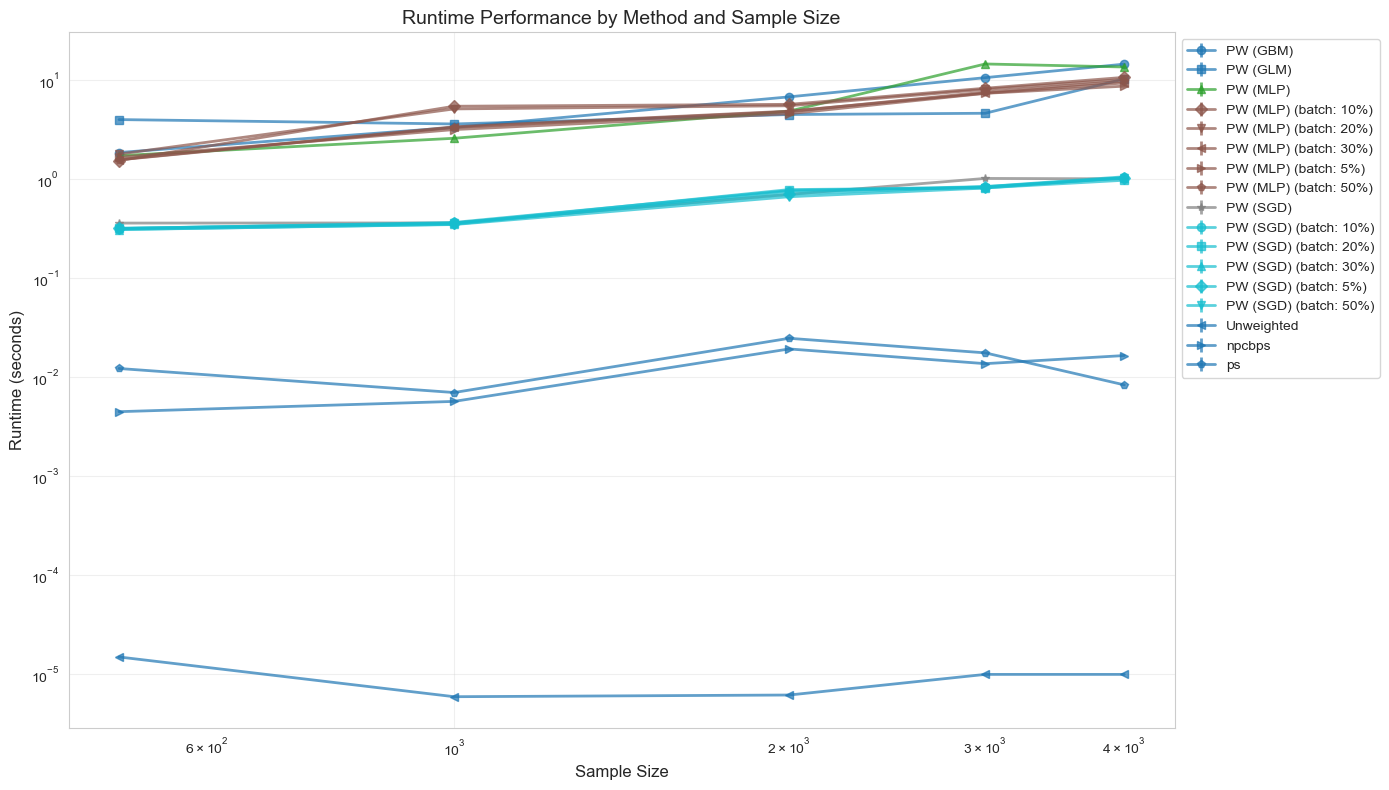

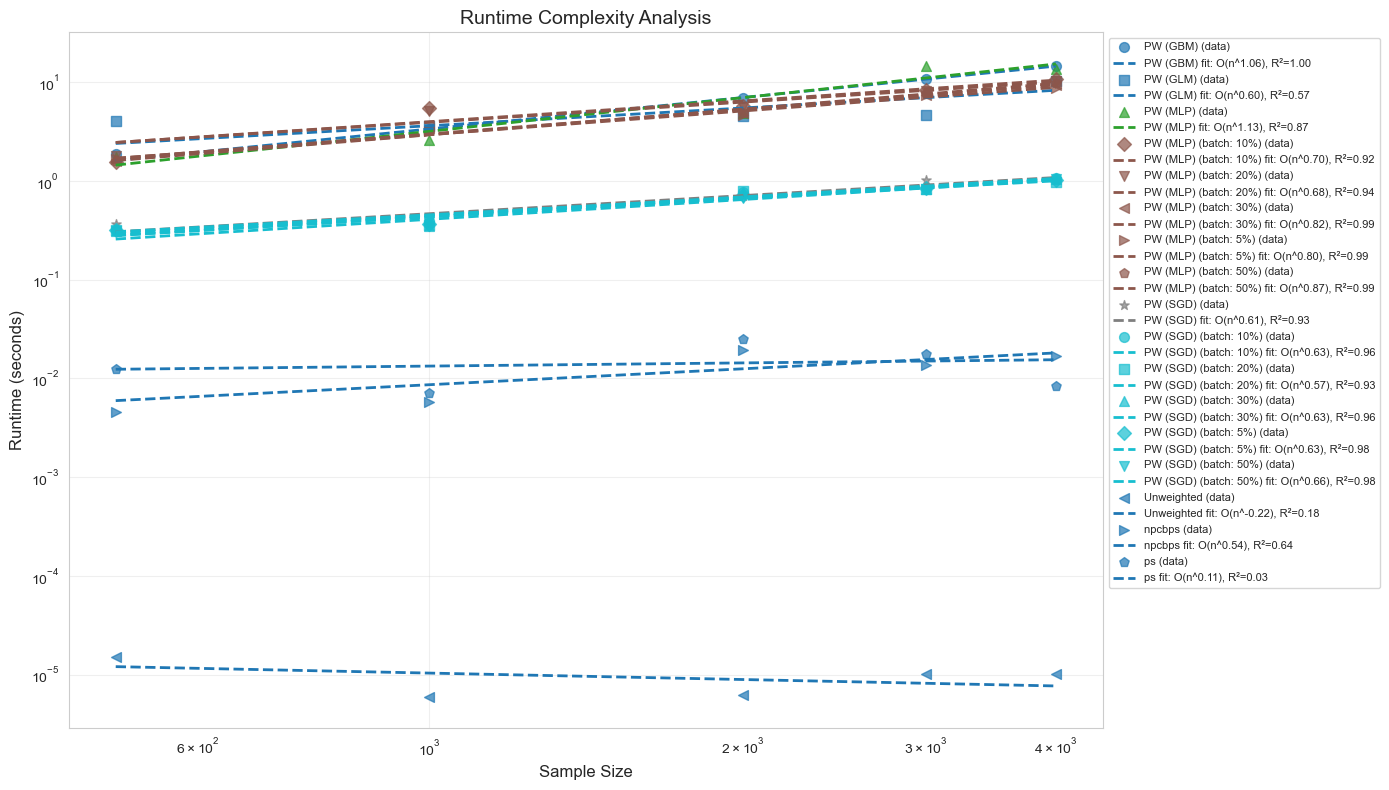

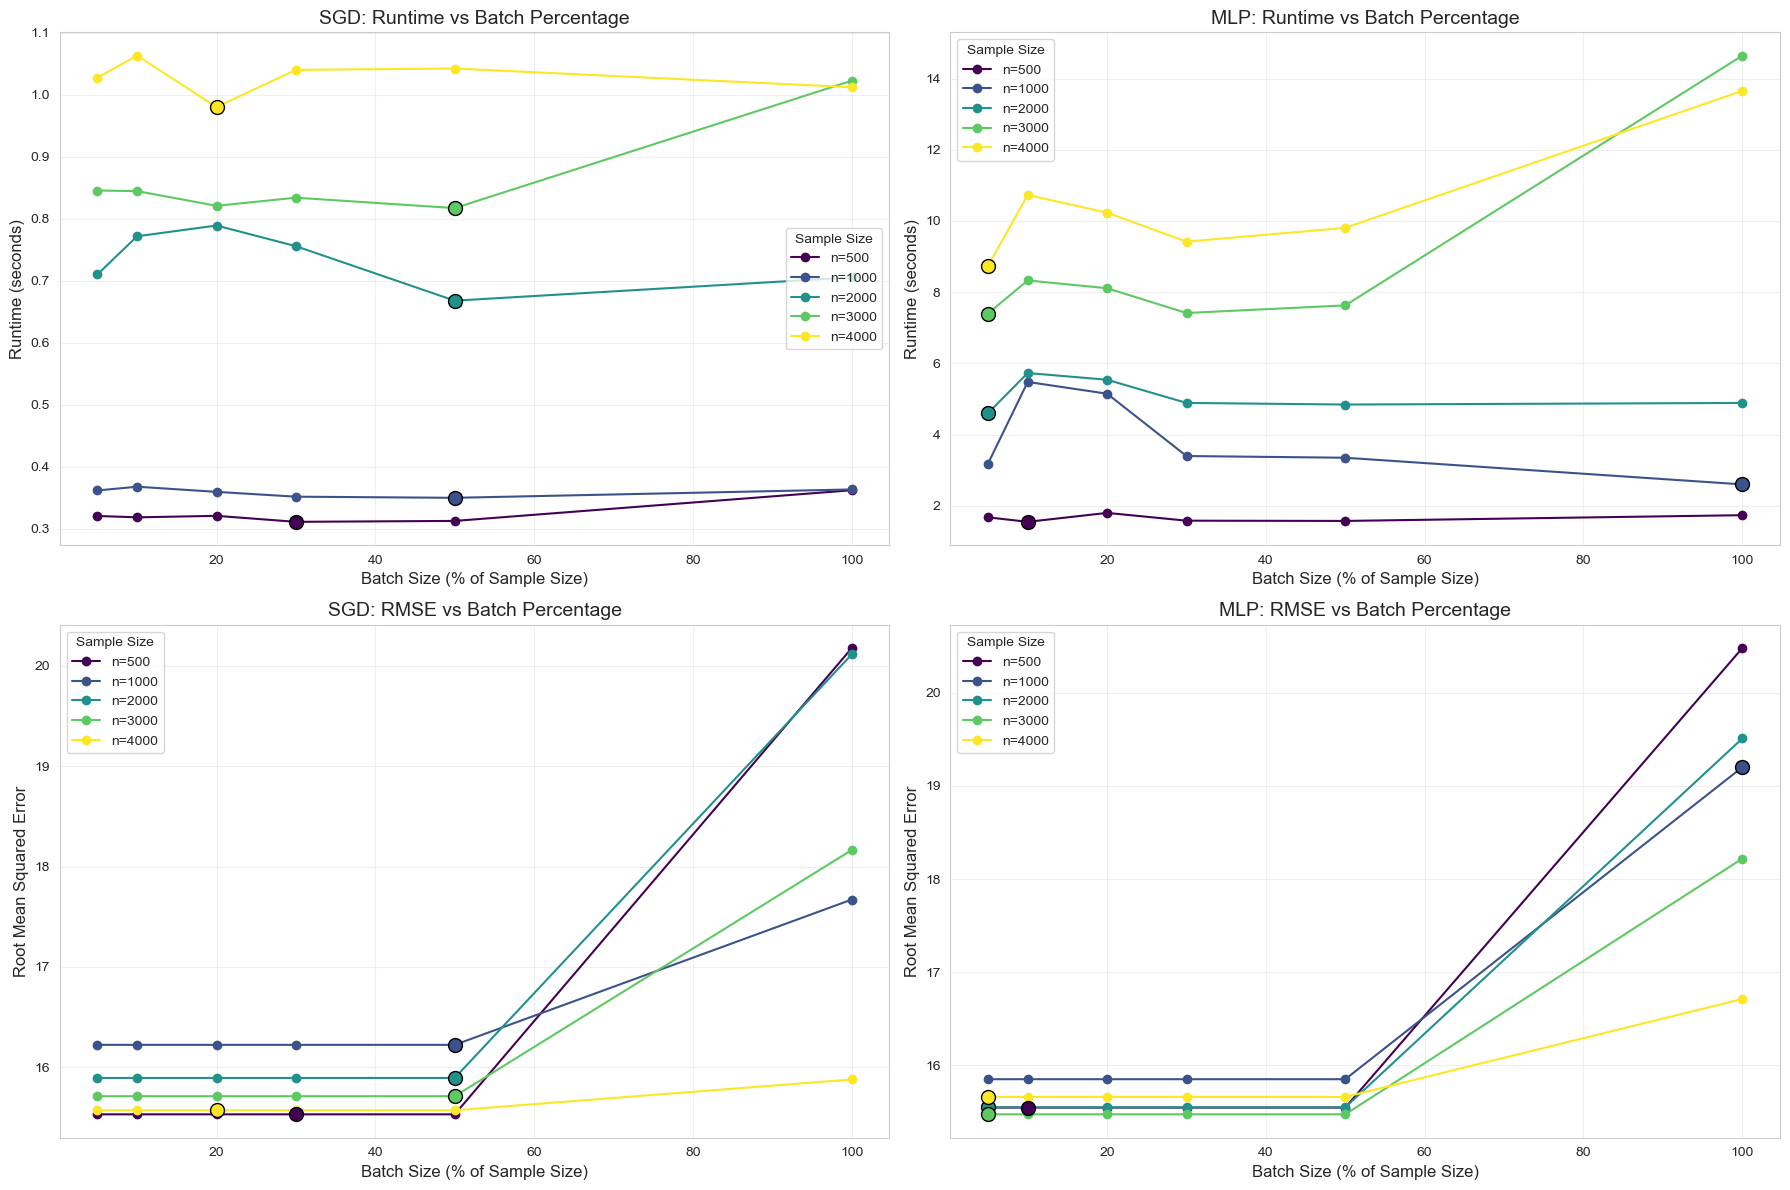

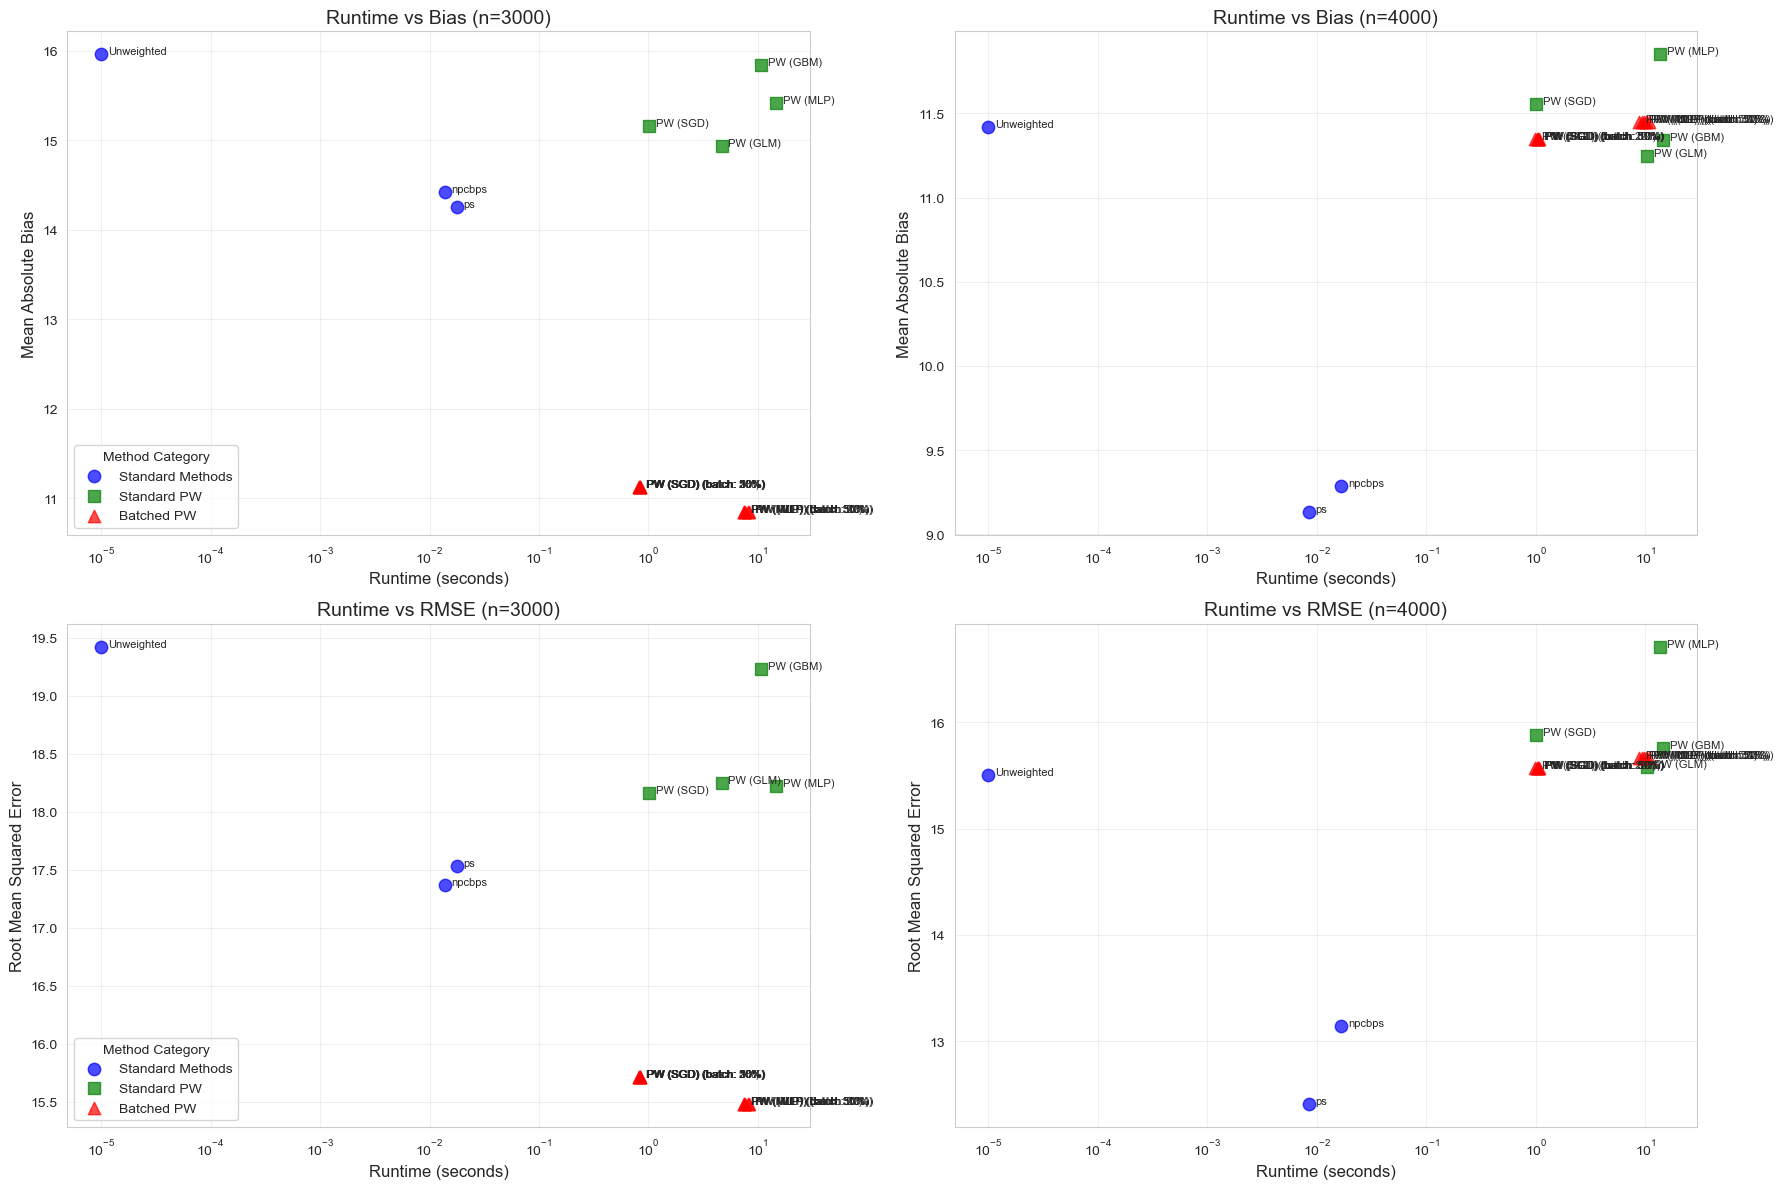

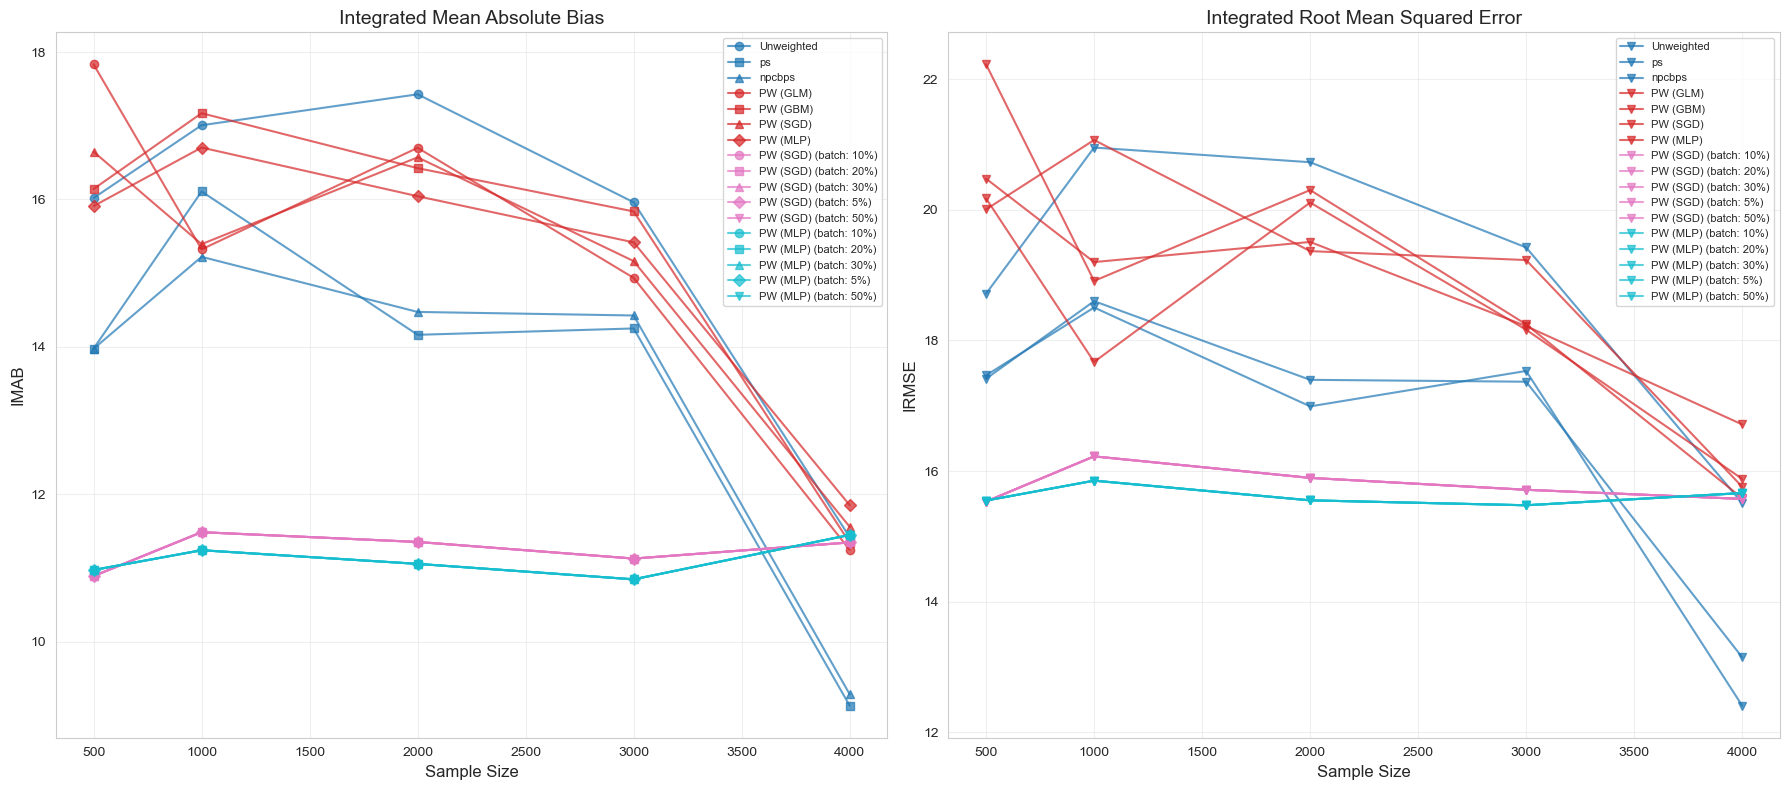

In [23]:

# Runtime analysis
print("Analyzing runtime performance...")
try:
    runtime_summary, complexity_df, runtime_fig, complexity_fig = analyze_runtime_performance(results)
    runtime_fig.savefig(f"{output_dir}/runtime_performance.png", dpi=300, bbox_inches='tight')
    complexity_fig.savefig(f"{output_dir}/runtime_complexity.png", dpi=300, bbox_inches='tight')
    complexity_df.to_csv(f"{output_dir}/complexity_analysis.csv", index=False)
except Exception as e:
    print(f"Error in runtime analysis: {e}")

# Batch size impact analysis
print("Analyzing batch size impact...")
try:
    optimal_batch_df, batch_impact_fig = analyze_batch_size_impact(results)
    if batch_impact_fig is not None:
        batch_impact_fig.savefig(f"{output_dir}/batch_size_impact.png", dpi=300, bbox_inches='tight')
    if not optimal_batch_df.empty:
        optimal_batch_df.to_csv(f"{output_dir}/optimal_batch_sizes.csv", index=False)
except Exception as e:
    print(f"Error in batch size impact analysis: {e}")

# Accuracy vs runtime analysis
print("Analyzing accuracy vs runtime trade-off...")
try:
    tradeoff_summary, tradeoff_fig = analyze_accuracy_vs_runtime(results)
    tradeoff_fig.savefig(f"{output_dir}/accuracy_runtime_tradeoff.png", dpi=300, bbox_inches='tight')
    tradeoff_summary.to_csv(f"{output_dir}/tradeoff_summary.csv", index=False)
except Exception as e:
    print(f"Error in accuracy vs runtime analysis: {e}")

# Accuracy metrics analysis
print("Analyzing accuracy metrics...")
try:
    metrics_df, accuracy_fig = analyze_accuracy_metrics(results)
    accuracy_fig.savefig(f"{output_dir}/accuracy_metrics.png", dpi=300, bbox_inches='tight')
    metrics_df.to_csv(f"{output_dir}/accuracy_metrics.csv", index=False)
except Exception as e:
    print(f"Error in accuracy metrics analysis: {e}")

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Complete analysis finished in {elapsed_time/60:.2f} minutes")

# Print summary of findings
print("\nSummary of Findings:")
print("===================")

# Print optimal batch percentages
if 'optimal_batch_df' in locals() and not optimal_batch_df.empty:
    print("\nOptimal Batch Percentages:")
    
    for classifier in optimal_batch_df['classifier'].unique():
        classifier_data = optimal_batch_df[optimal_batch_df['classifier'] == classifier]
        
        if not classifier_data.empty:
            avg_pct = classifier_data['optimal_batch_pct'].mean() * 100
            print(f"  {classifier}: {avg_pct:.1f}% of sample size is optimal on average")
            
            # Print by sample size
            for _, row in classifier_data.iterrows():
                print(f"    n={int(row['sample_size'])}: {row['optimal_batch_pct']*100:.1f}% ({row['optimal_batch_size']} samples)")

# Print runtime complexity
if 'complexity_df' in locals() and not complexity_df.empty:
    print("\nRuntime Complexity:")
    
    for _, row in complexity_df.sort_values('exponent').iterrows():
        print(f"  {row['method']}: O(n^{row['exponent']:.2f}) (R² = {row['r_squared']:.2f})")

# Print performance comparison for largest sample size
if 'tradeoff_summary' in locals() and not tradeoff_summary.empty:
    max_sample = tradeoff_summary['sample_size'].max()
    large_sample_data = tradeoff_summary[tradeoff_summary['sample_size'] == max_sample]
    
    if not large_sample_data.empty:
        print(f"\nPerformance at n={max_sample}:")
        
        # Sort by runtime
        for _, row in large_sample_data.sort_values('avg_runtime').iterrows():
            print(f"  {row['method']}: {row['avg_runtime']:.3f}s, bias={row['bias']:.4f}, rmse={row['rmse']:.4f}")

# Calculate and print speedups
print("\nSpeedup from Batching:")

# Compare standard PW to batched PW for largest sample size
runtime_data = results[results['runtime'].notna()].copy()
max_sample = runtime_data['sample_size'].max()
large_sample_results = runtime_data[runtime_data['sample_size'] == max_sample]

for base in ['SGD', 'MLP']:
    # Get standard method runtime
    standard_method = f"PW ({base})"
    standard_runtime = large_sample_results[large_sample_results['method'] == standard_method]['runtime'].mean()
    
    # Get best batched method runtime
    batched_methods = [m for m in large_sample_results['method'].unique() if f"{base}" in m and "(batch:" in m]
    
    if batched_methods and not np.isnan(standard_runtime):
        batched_runtimes = []
        
        for method in batched_methods:
            runtime = large_sample_results[large_sample_results['method'] == method]['runtime'].mean()
            batched_runtimes.append((method, runtime))
        
        if batched_runtimes:
            # Find best batched method
            best_method, best_runtime = min(batched_runtimes, key=lambda x: x[1])
            
            # Calculate speedup
            speedup = standard_runtime / best_runtime
            
            print(f"  {standard_method} vs {best_method}: {speedup:.2f}x speedup")

print("\nAnalysis completed. All results saved to:", output_dir)


Running well-specified continuous Kang-Schafer simulation...
  Sample size: 100
    Simulation 1/2
Error in evaluate_treatment_effect for ps, sim 0, n=100: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for Unweighted, sim 1, n=100: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for PW-sgd, sim 1, n=100: b'Extrapolation not allowed with blending'
  Sample size: 150
    Simulation 1/2
Error in evaluate_treatment_effect for npcbps, sim 1, n=150: b'Extrapolation not allowed with blending'
  Sample size: 200
    Simulation 1/2
Error in evaluate_treatment_effect for Unweighted, sim 1, n=200: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for ps, sim 1, n=200: b'Extrapolation not allowed with blending'
  Sample size: 300
    Simulation 1/2
  Sample size: 500
    Simulation 1/2


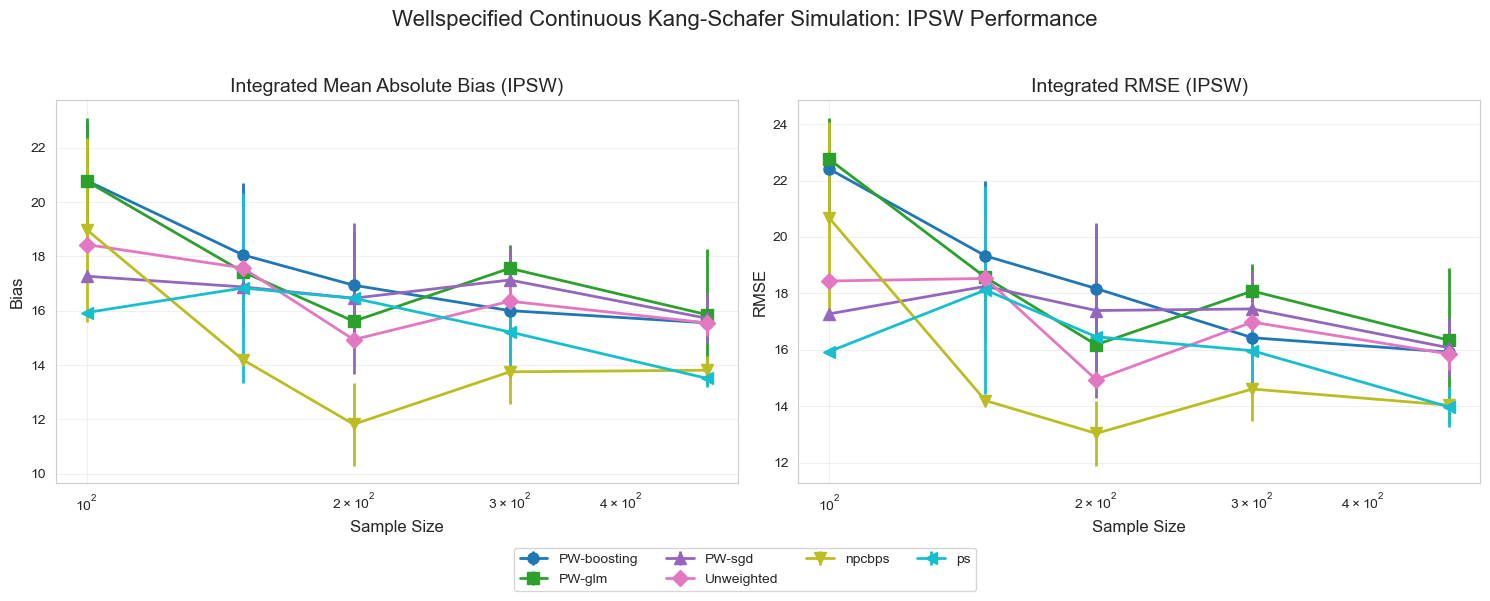

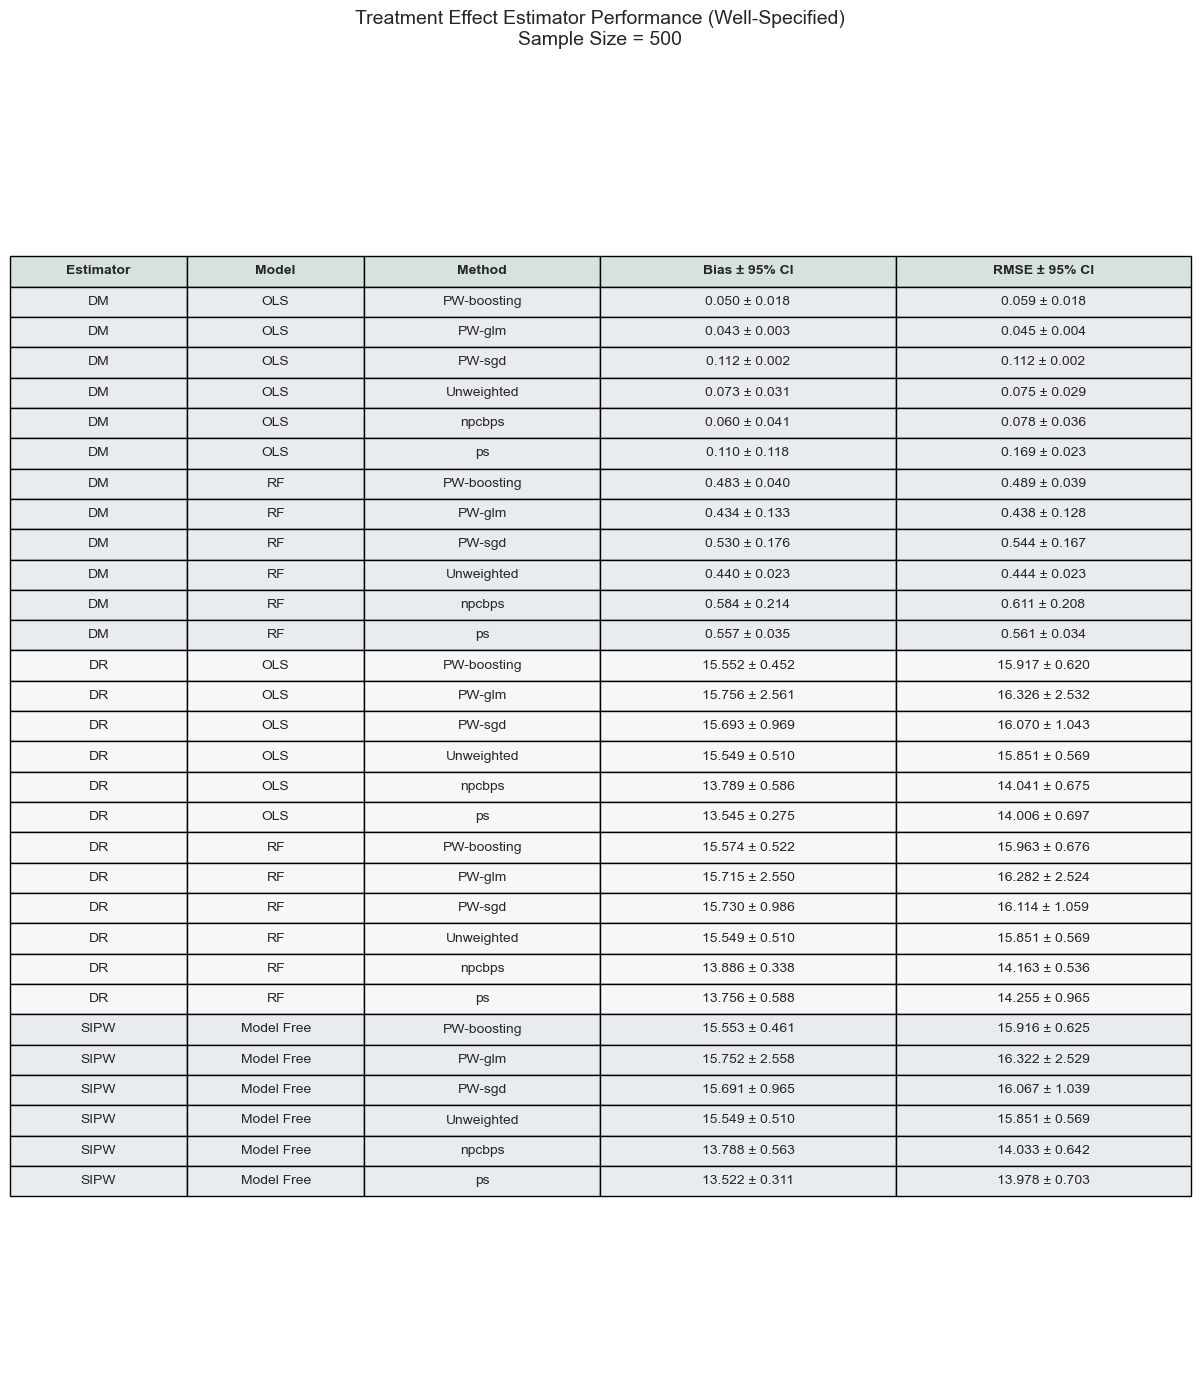

In [2]:
sample_sizes = [100,150 ,200, 300, 500]
n_sims = 2 # Even more reduced for testing
methods = ['Unweighted', 'ps', 'npcbps', 'PW (GLM)', 'PW (GBM)','PW (SGD)' ]  # Reduced set of methods

# Run well-specified simulation
start_time = time.time()
well_specified_results = run_simulation(
    sample_sizes=sample_sizes,
    n_sims=n_sims,
    methods=methods,
    misspecified=False
)
# print(f"Well-specified simulation completed in {time.time() - start_time:.1f} seconds")
# 
# # Run misspecified simulation
# start_time = time.time()
# misspecified_results = run_simulation(
#     sample_sizes=sample_sizes,
#     n_sims=n_sims,
#     methods=methods,
#     misspecified=True
# )
# print(f"Misspecified simulation completed in {time.time() - start_time:.1f} seconds")
# 
# Plot IPSW results for both well-specified and misspecified
ipsw_fig_well = plot_ipsw_results(well_specified_results, misspecified=False )
#ipsw_fig_miss = plot_ipsw_results(misspecified_results, misspecified=True)


# Create tables for all estimators at highest sample size
max_sample_size = max(sample_sizes)
table_fig_well = create_estimator_table(well_specified_results, max_sample_size, "Well-Specified")
#table_fig_mis = create_estimator_table(misspecified_results, max_sample_size, "Misspecified")
    

In [5]:
def plot_runtime_performance(results):
    """
    Plot the runtime performance of each weighting method across different sample sizes.
    
    Parameters:
    -----------
    results : DataFrame
        DataFrame containing simulation results with a 'Runtime' metric
        
    Returns:
    --------
    matplotlib.figure.Figure: The generated figure
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Filter to only include runtime metrics
    runtime_data = results[results['metric'] == 'Runtime'].copy()
    
    # Calculate average and std dev of runtimes for each method and sample size
    runtime_stats = runtime_data.groupby(['method', 'sample_size']).agg(
        avg_runtime=('value', 'mean'),
        std_runtime=('value', 'std'),
        count=('value', 'count')
    ).reset_index()
    
    # Calculate 95% confidence intervals
    runtime_stats['ci'] = 1.96 * runtime_stats['std_runtime'] / np.sqrt(runtime_stats['count'])
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define colors and markers for methods
    methods = runtime_stats['method'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
    method_colors = {method: colors[i] for i, method in enumerate(methods)}
    
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    method_markers = {method: markers[i % len(markers)] for i, method in enumerate(methods)}
    
    # Plot each method
    for method in methods:
        method_data = runtime_stats[runtime_stats['method'] == method]
        
        if len(method_data) > 0:
            ax.errorbar(
                method_data['sample_size'],
                method_data['avg_runtime'],
                yerr=method_data['ci'],
                color=method_colors[method],
                marker=method_markers[method],
                markersize=8,
                linewidth=2,
                label=method
            )
    
    # Set labels and title
    ax.set_title('Runtime Performance by Method and Sample Size', fontsize=16)
    ax.set_xlabel('Sample Size', fontsize=14)
    ax.set_ylabel('Average Runtime (seconds)', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, which='both')
    
    # Add legend
    ax.legend(fontsize=12, loc='best')
    
    # Add annotations for scaling behavior
    for method in methods:
        method_data = runtime_stats[runtime_stats['method'] == method]
        if len(method_data) >= 2:
            # Get the smallest and largest sample sizes for slope calculation
            first = method_data.iloc[0]
            last = method_data.iloc[-1]
            
            # Calculate approximate scaling factor
            if last['sample_size'] > first['sample_size'] and last['avg_runtime'] > first['avg_runtime']:
                scaling = np.log(last['avg_runtime'] / first['avg_runtime']) / np.log(last['sample_size'] / first['sample_size'])
                
                # Add annotation to the right of the last point
                ax.annotate(
                    f"~O(n^{scaling:.1f})",
                    xy=(last['sample_size']*1.05, last['avg_runtime']),
                    color=method_colors[method],
                    fontsize=10,
                    va='center'
                )
    
    plt.tight_layout()
    return fig

def bootstrap_runtime(results, B=200):
    """
    Bootstrap the runtime statistics to get more robust estimates.
    
    Parameters:
    -----------
    results : DataFrame
        DataFrame containing simulation results with a 'Runtime' metric
    B : int
        Number of bootstrap iterations
        
    Returns:
    --------
    DataFrame: Results with bootstrapped runtime statistics
    """
    # Filter to only include runtime metrics
    df = results[results['metric'] == 'Runtime'].copy()
    
    # Initialize storage for bootstrap results
    bootstrap_results = []
    
    for b in range(B):
        # Sample iterations with replacement
        sampled_iters = np.random.choice(df['simulation'].unique(), 
                                        size=len(df['simulation'].unique()), 
                                        replace=True)
        
        # Create bootstrapped dataset by combining sampled iterations
        bootstrap_df = pd.concat([df[df['simulation'] == iter_id] for iter_id in sampled_iters])
        
        # Calculate statistics by method and sample size
        runtime_by_method = bootstrap_df.groupby(['sample_size', 'method']).agg(
            runtime=('value', 'mean')
        ).reset_index()
        
        bootstrap_results.append(runtime_by_method)
    
    # Combine all bootstrap results
    all_bootstraps = pd.concat(bootstrap_results, ignore_index=True)
    
    # Calculate mean and standard error of runtime for each group
    final_results = all_bootstraps.groupby(['sample_size', 'method']).agg(
        value=('runtime', 'mean'),
        sem=('runtime', 'std')
    ).reset_index()
    
    # Add metric column to identify these results
    final_results['metric'] = 'Runtime (bootstrapped)'
    
    return final_results

def analyze_runtime_complexity(results):
    """
    Analyze the computational complexity of each method by fitting power laws.
    
    Parameters:
    -----------
    results : DataFrame
        DataFrame containing simulation results with a 'Runtime' metric
        
    Returns:
    --------
    DataFrame: Results with complexity analysis
    matplotlib.figure.Figure: The generated figure showing fitted complexity curves
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.optimize import curve_fit
    
    # Filter to only include runtime metrics
    runtime_data = results[results['metric'] == 'Runtime'].copy()
    
    # Calculate average runtime for each method and sample size
    runtime_avg = runtime_data.groupby(['method', 'sample_size']).agg(
        avg_runtime=('value', 'mean')
    ).reset_index()
    
    # Function to fit for complexity analysis (power law: y = a * x^b)
    def power_law(x, a, b):
        return a * np.power(x, b)
    
    # Store results of complexity analysis
    complexity_results = []
    
    # Create figure for complexity analysis
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define colors for methods
    methods = runtime_avg['method'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
    method_colors = {method: colors[i] for i, method in enumerate(methods)}
    
    # For each method, fit a power law curve
    for method in methods:
        method_data = runtime_avg[runtime_avg['method'] == method]
        
        if len(method_data) > 2:  # Need at least 3 points for a good fit
            x_data = method_data['sample_size'].values
            y_data = method_data['avg_runtime'].values
            
            try:
                # Fit power law
                popt, pcov = curve_fit(power_law, x_data, y_data)
                a, b = popt
                
                # Calculate R-squared
                y_pred = power_law(x_data, a, b)
                ss_total = np.sum((y_data - np.mean(y_data))**2)
                ss_residual = np.sum((y_data - y_pred)**2)
                r_squared = 1 - (ss_residual / ss_total)
                
                # Store results
                complexity_results.append({
                    'method': method,
                    'coefficient': a,
                    'exponent': b,
                    'r_squared': r_squared
                })
                
                # Plot actual data points
                ax.scatter(
                    x_data, 
                    y_data, 
                    color=method_colors[method], 
                    label=f"{method} (actual)"
                )
                
                # Plot fitted curve
                x_fit = np.linspace(min(x_data), max(x_data), 100)
                ax.plot(
                    x_fit,
                    power_law(x_fit, a, b),
                    color=method_colors[method],
                    linestyle='--',
                    label=f"{method} fit: O(n^{b:.2f}), R²={r_squared:.2f}"
                )
                
            except Exception as e:
                print(f"Could not fit power law for {method}: {e}")
    
    # Set labels and title
    ax.set_title('Runtime Complexity Analysis', fontsize=16)
    ax.set_xlabel('Sample Size (n)', fontsize=14)
    ax.set_ylabel('Runtime (seconds)', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, which='both')
    
    # Add legend
    ax.legend(fontsize=10, loc='best')
    
    plt.tight_layout()
    
    return pd.DataFrame(complexity_results), fig

        method  coefficient  exponent  r_squared
0  PW-boosting     0.021662  0.800363   0.963973
1       PW-glm     0.904537  0.088113   0.236017
2       PW-sgd     0.060194  0.421153   0.676328
3   Unweighted     0.000006 -0.047262   0.012875
4       npcbps     0.012349 -0.406304   0.333842
5           ps     0.016204 -0.346089   0.078652


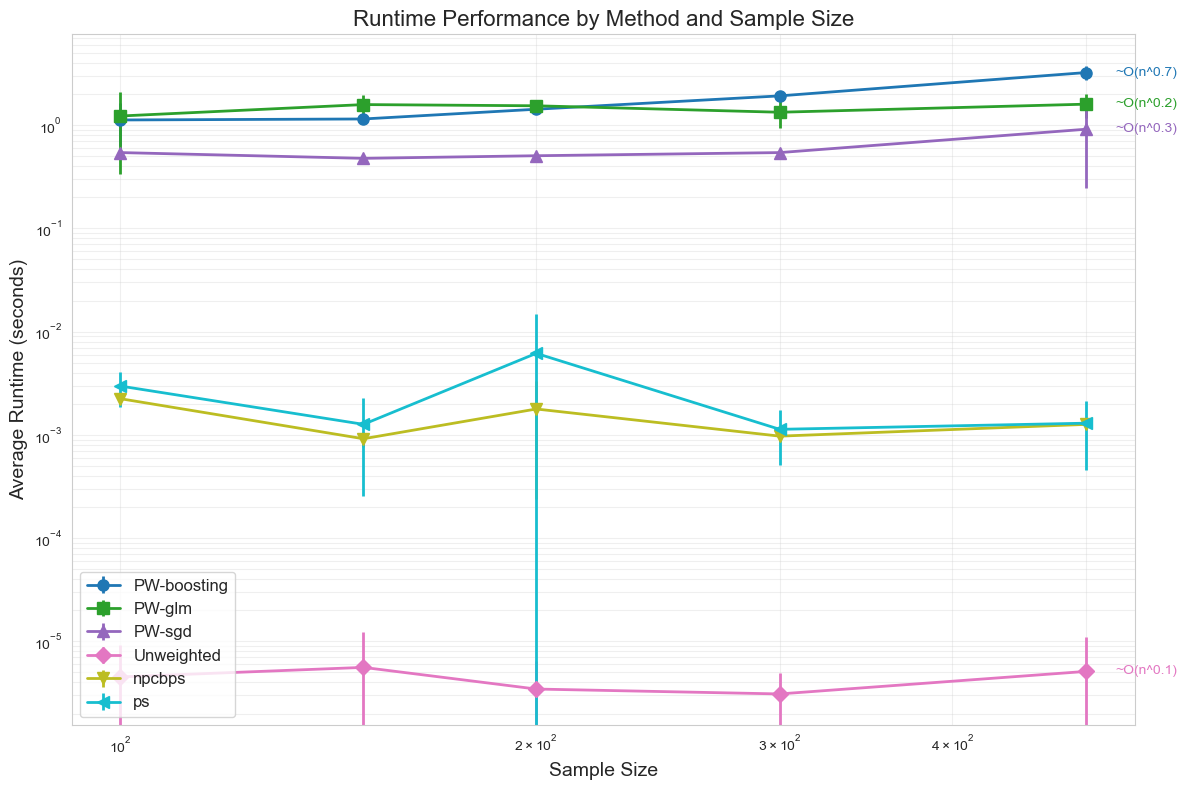

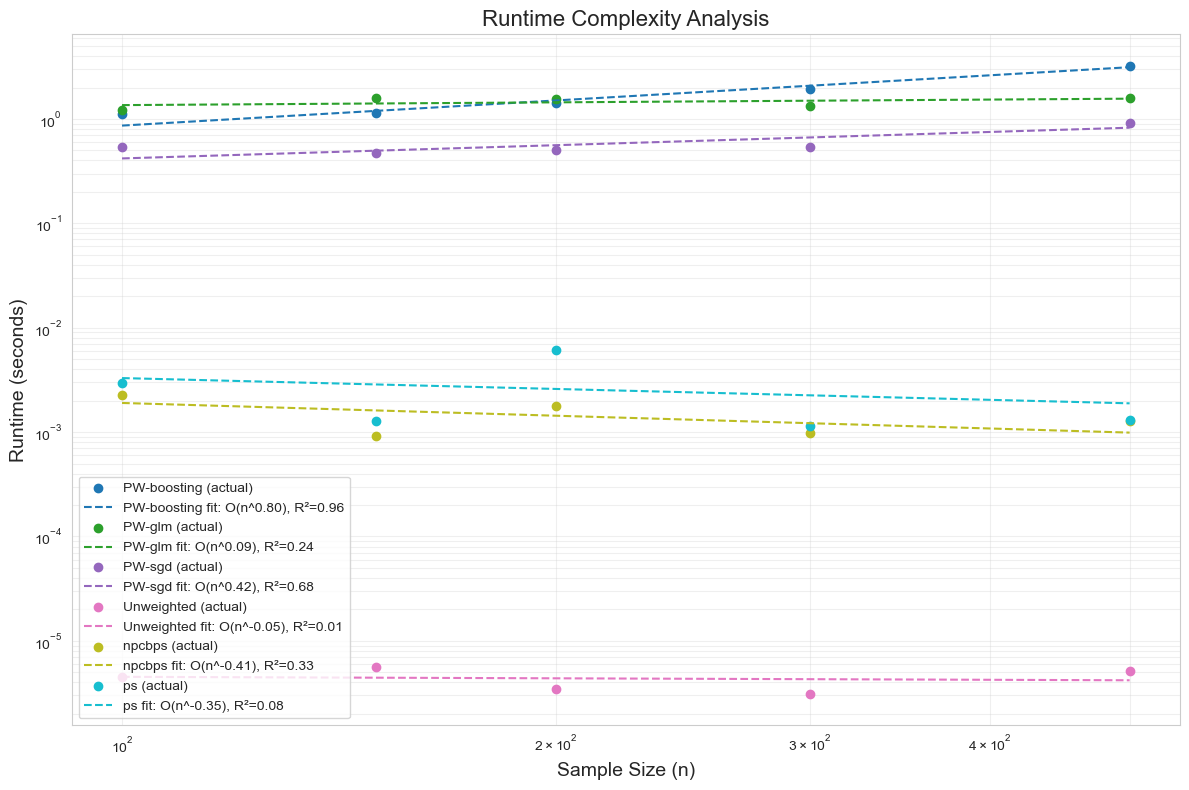

In [7]:
# Run your simulation
runtime_fig = plot_runtime_performance(well_specified_results)

# For more detailed analysis
bootstrapped_runtime = bootstrap_runtime(well_specified_results)
complexity_results, complexity_fig = analyze_runtime_complexity(well_specified_results)

# Print complexity results
print(complexity_results)

# Save figures
# runtime_fig.savefig('runtime_performance.png', dpi=300)
# complexity_fig.savefig('runtime_complexity.png', dpi=300)